In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# imports cell
import sys 
import matplotlib.pyplot as plt
import scipy as sp
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import numpy as np
import _pickle as cPickle
import random, sys, keras
import gc
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize 
import scipy.integrate as it
from sklearn import preprocessing

# import tensorflow as tf
# import gc

In [3]:
# filepath = "/content/drive/My Drive/7th Term Assignments, Sheets & Labs/Modulation_classification/data/" # Yomna
filepath = "/content/drive/MyDrive/College/Data_Mining_Assignments/Modulation_classification/data" # Arsany
# filepath = "/content/drive/MyDrive/Modulation_classification/data" # Kiro
os.chdir(filepath)

May help: https://github.com/LionAE/modulation-recognition-for-wireless-signals

2-
https://erichizdepski.wordpress.com/2019/05/23/using-machine-learning-to-categorize-radio-signals/


## **Download Data**

In [ ]:
# you do not need to run this cell if you have an access to google drive.
# download the dataset.
!wget http://opendata.deepsig.io/datasets/2016.10/RML2016.10b.tar.bz2
!tar -xf RML2016.10b.tar.bz2.1

--2020-12-31 01:59:38--  http://opendata.deepsig.io/datasets/2016.10/RML2016.10b.tar.bz2
Resolving opendata.deepsig.io (opendata.deepsig.io)... 52.14.91.165
Connecting to opendata.deepsig.io (opendata.deepsig.io)|52.14.91.165|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1245608913 (1.2G) [application/x-bzip2]
Saving to: ‘RML2016.10b.tar.bz2.1’

RML2016.10b.tar.bz2 100%[===================>]   1.16G  13.3MB/s    in 89s     

2020-12-31 02:01:08 (13.3 MB/s) - ‘RML2016.10b.tar.bz2.1’ saved [1245608913/1245608913]



# **Loading data**

In [4]:
with open('RML2016.10b.dat', 'rb') as f:
    Xd = cPickle.load(f, encoding="latin1") 
 
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []
lbl = []
for mod in mods:
    # mod is the label. mod = modulation scheme
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        #snr = signal to noise ratio
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

# **Create feature Spaces**

### 1. Raw time series as given (two channels)

In [ ]:
# if want n * 2 * 128
X_raw = X[:,0], X[:,1]
X_raw = np.asarray(X_raw)
print(X_raw.shape)

(1200000, 256)


In [ ]:
# if want n * 256
X_raw = np.reshape(X_raw, (1200000,256))
print(X_raw.shape)

array([[ 0.00907056,  0.00599482, -0.0035653 , ..., -0.00607358,
        -0.0072575 , -0.00728448],
       [-0.00419709, -0.01053281, -0.00680017, ...,  0.00162549,
        -0.00118617,  0.005617  ],
       [ 0.00174664, -0.0084256 ,  0.00147178, ...,  0.00198796,
        -0.00023271,  0.00323295],
       ...,
       [ 0.0027236 ,  0.00265014,  0.00258855, ..., -0.00736364,
        -0.00733167, -0.00727415],
       [ 0.00396798,  0.00391821,  0.00399417, ..., -0.00657877,
        -0.00664485, -0.00665402],
       [ 0.00492854,  0.00492476,  0.00497359, ..., -0.00614814,
        -0.00601163, -0.0059941 ]], dtype=float32)

In [ ]:
# delete X_raw and collect garbage
del(X_raw)
gc.collect()

56

### 2. First derivative in time (two channels)

In [ ]:
# if want n * 2 * 128
X_der = np.apply_along_axis(lambda column:np.gradient(column),2,X)
X_der = np.asarray(X_der)
print(X_der.shape)

(1200000, 2, 128)


In [ ]:
# # if want n * 256
# X_der = np.reshape(X_der, (1200000,256))
# print(X_der.shape)

(1200000, 256)


In [ ]:
# # delete X_der and collect garbage
# del(X_der)
# gc.collect()

36

### 3. Integral in time (two channels)

In [ ]:
# if want n * 2 * 128
X_int = np.apply_along_axis(lambda column:np.hstack((0,column)),2,np.apply_along_axis(lambda column:sp.integrate.cumtrapz(column,dx=1,axis=-1),2,X))
X_int = np.asarray(X_int)
print(X_int.shape)

(1200000, 2, 128)


In [ ]:
# # if want n * 256
# X_int = np.reshape(X_int, (1200000,256))
# print(X_int.shape)

In [ ]:
# # delete X_int and collect garbage
# del(X_int)
# gc.collect()

0

### 4. combinations of 1,2 and 3. (More channels)

In [ ]:
# if want n * 4 * 128
com_three_X = np.concatenate((np.apply_along_axis(lambda column:np.gradient(column),2,X) ,np.apply_along_axis(lambda column:np.hstack((0,column)),2,np.apply_along_axis(lambda column:sp.integrate.cumtrapz(column,dx=1,axis=-1),2,X))),axis=1)
print(com_three_X.shape)
com_three_X = np.asarray(com_three_X)
print(com_three_X.shape)

(1200000, 4, 128)
(1200000, 4, 128)


In [ ]:
# # if want n * 512
# com_three_X = np.reshape(com_three_X, (1200000,512))

In [ ]:
# # delete com_three_X and collect garbage
# del(com_three_X)
# gc.collect()

# **Supervised Learning Step**

flatten the X train and test

In [ ]:
nsamples, nx, ny = trainX.shape
X_train = trainX.reshape((nsamples,nx*ny))

nsamples, nx, ny = testX.shape
X_test = testX.reshape((nsamples,nx*ny))

nsamples, nx, ny = valX.shape
X_val = valX.reshape((nsamples,nx*ny))

print(X_train.shape)

print(X_test.shape)

print(X_val.shape)

(798000, 256)
(360000, 256)
(42000, 256)


In [ ]:
# Partition the data
#  into training and test sets of the form we can train/test on
#  while keeping SNR and Mod labels handy for each
n_examples = X.shape[0]
# looks like taking half the samples for training
n_train = int(n_examples * 0.7)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
# X_train = X[train_idx]
# X_test =  X[test_idx]

def to_onehot(yy):
    data = list(yy)
    yy1 = np.zeros([len(data), max(data)+1])
    yy1[np.arange(len(data)),data] = 1
    return yy1
Y_train = to_onehot(map(lambda x: mods.index(lbl[x][0]), train_idx))
Y_test = to_onehot(map(lambda x: mods.index(lbl[x][0]), test_idx))

(X_train, X_val, Y_train, Y_val) = train_test_split(X_train, Y_train, test_size=0.05)
print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)
print(X_test.shape,Y_test.shape)

(798000, 2, 128) (798000, 10)
(42000, 2, 128) (42000, 10)
(360000, 2, 128) (360000, 10)


### Classifiers

In [ ]:
# passed parameters
# X_train - X_test - X_val

# trainY_mods - trainY_snr

# testY_mods - testY_snr

# valY_mods - valY_snr

Logistic Regression Classifier

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score

logistic_regression = LogisticRegression(max_iter=1000)
scaler = MinMaxScaler()
normalized_X_train = scaler.fit_transform(X_train)
normalized_X_test = scaler.transform(X_test)
normalized_X_val = scaler.transform(X_val)
logistic_regression_model = logistic_regression.fit(normalized_X_train, trainY_mods)

In [ ]:
import pickle
pickle.dump(logistic_regression_model, open(f'/content/drive/MyDrive/College/Data_Mining_Assignments/Modulation_classification/models/logistic_regression.sav', 'wb'))

# loaded_model = pickle.load(open(f'/content/drive/MyDrive/College/Data_Mining_Assignments/Modulation_classification/models/logistic_regression.sav', 'rb'))

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(labels))
  plt.xticks(tick_marks, labels, rotation=45)
  plt.yticks(tick_marks, labels)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

SNR =  -20

Accuracy =  0.10256979519342843
Train Accuracy =  0.11099400235890487
Validation Accuracy =  0.09044048734770384
SNR =  -18

Accuracy =  0.10448010698762955
Train Accuracy =  0.11239164203036528
Validation Accuracy =  0.08644859813084112
SNR =  -16

Accuracy =  0.10377305913169481
Train Accuracy =  0.1156496554479177
Validation Accuracy =  0.10773067331670823
SNR =  -14

Accuracy =  0.10491382676111329
Train Accuracy =  0.11780465209444403
Validation Accuracy =  0.09896810506566604
SNR =  -12

Accuracy =  0.11477499445799158
Train Accuracy =  0.12919273385090826
Validation Accuracy =  0.10951276102088167
SNR =  -10

Accuracy =  0.14311967477863785
Train Accuracy =  0.1559120945134161
Validation Accuracy =  0.09995217599234815
SNR =  -8

Accuracy =  0.17631739347259934
Train Accuracy =  0.18679996993159437
Validation Accuracy =  0.09784735812133072
SNR =  -6

Accuracy =  0.18837863167760074
Train Accuracy =  0.19243925750792293
Validation Accuracy =  0.10175939134569663
SNR 

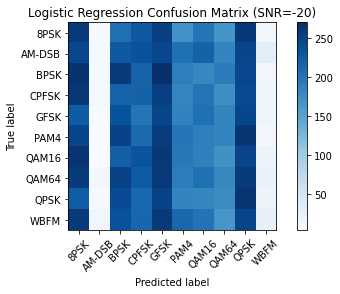

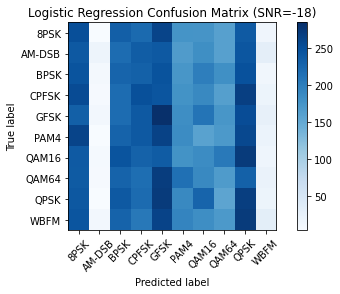

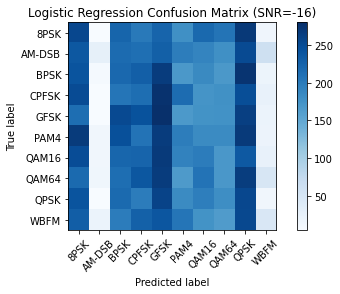

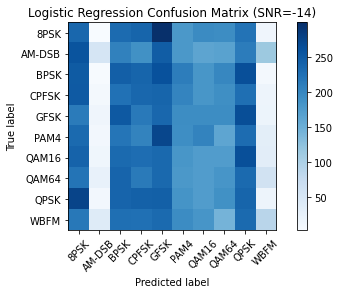

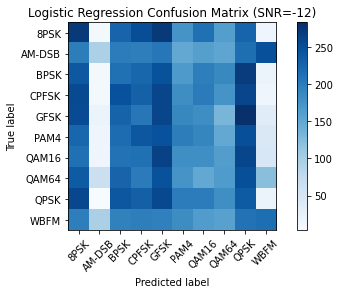

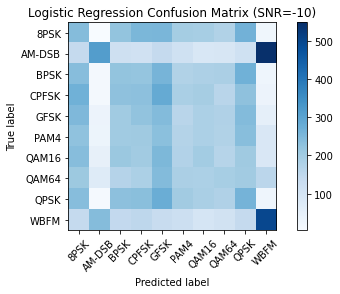

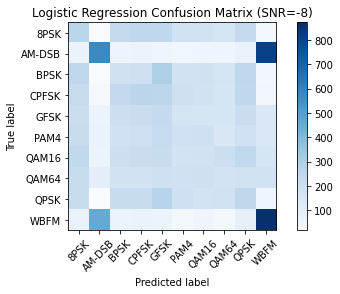

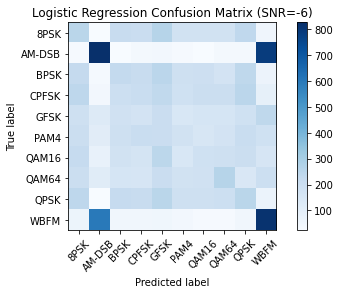

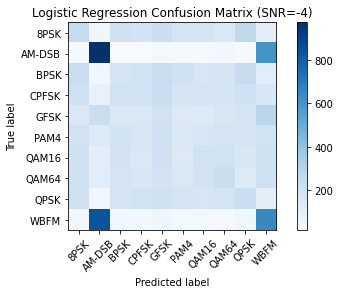

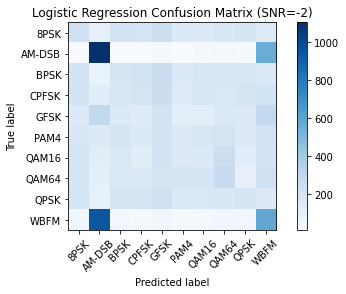

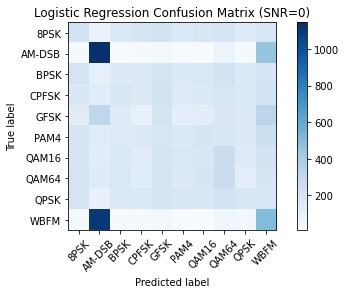

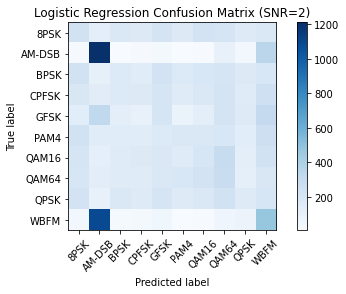

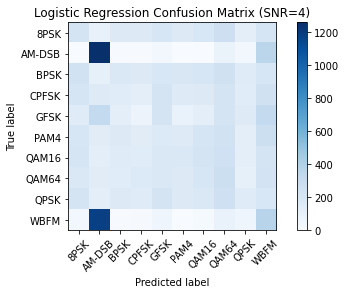

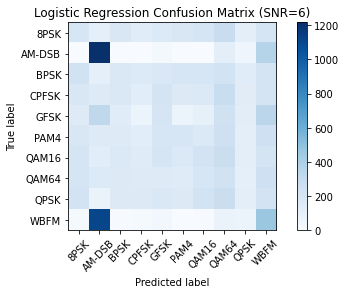

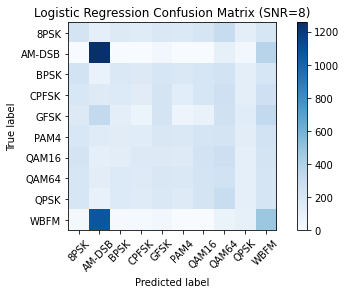

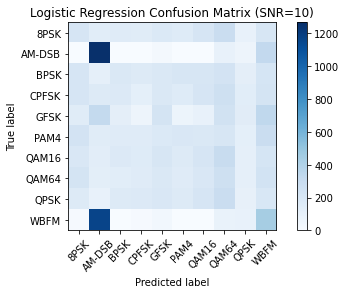

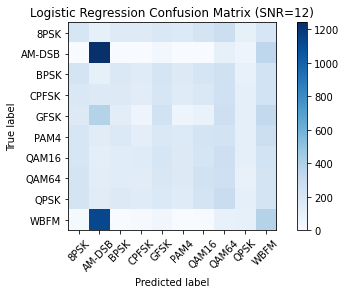

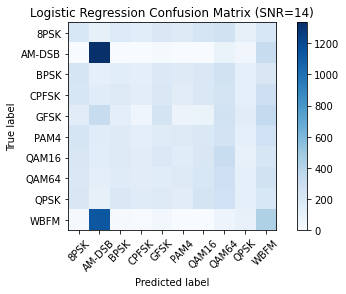

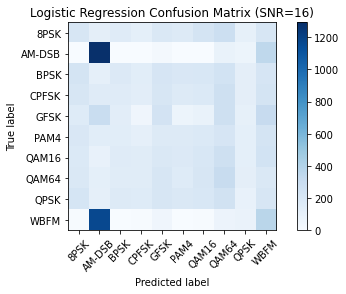

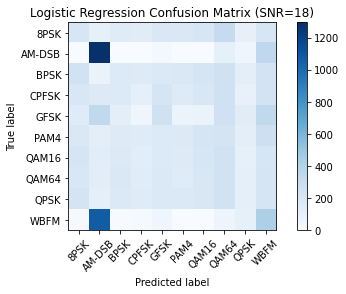

In [ ]:
acc = []
tr_acc = []
val_acc = []
for snr in snrs:
  print("SNR = ", snr)
  #test accuracy
  normalized_X_test_i = normalized_X_test[np.where(testY_snr == str(snr))]
  testY_mods_i = testY_mods[np.where(testY_snr == str(snr))]

  y_pred = logistic_regression_model.predict(normalized_X_test_i)
  accuracy = accuracy_score(y_pred, testY_mods_i)
  acc.append(accuracy)
  print("\nAccuracy = ", accuracy)

  #train accuracy
  normalized_X_train_i = normalized_X_train[np.where(trainY_snr == str(snr))]
  trainY_mods_i = trainY_mods[np.where(trainY_snr == str(snr))]

  y_pred_train = logistic_regression_model.predict(normalized_X_train_i)
  train_accuracy = accuracy_score(y_pred_train, trainY_mods_i)
  tr_acc.append(train_accuracy)
  print("Train Accuracy = ", train_accuracy)

  #validation accuracy
  X_val_i = X_val[np.where(valY_snr == str(snr))]
  valY_mods_i = valY_mods[np.where(valY_snr == str(snr))]

  y_pred_val = logistic_regression_model.predict(X_val_i)
  val_accuracy = accuracy_score(y_pred_val, valY_mods_i)
  val_acc.append(val_accuracy)
  print("Validation Accuracy = ", val_accuracy)

  conf = confusion_matrix(testY_mods_i, y_pred)
  plt.figure()
  plot_confusion_matrix(conf, labels=mods, title="Logistic Regression Confusion Matrix (SNR=%d)"%(snr))

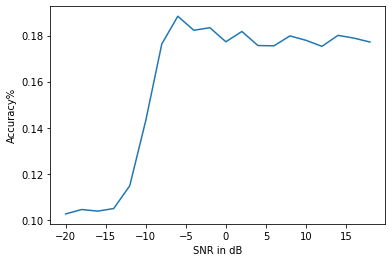

In [ ]:
# Plot the data
plt.plot(snrs, acc)
plt.xlabel('SNR in dB')
plt.ylabel('Accuracy%')
# Show the plot
plt.show()

Decision ​ Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
# from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score

decision_tree = DecisionTreeClassifier()
# scaler = MinMaxScaler()
# normalized_X_train = scaler.fit_transform(X_train)
# normalized_X_test = scaler.transform(X_test)
# normalized_X_val = scaler.transform(X_val)
decision_tree_model = decision_tree.fit(X_train, trainY_mods)

In [ ]:
import pickle
pickle.dump(decision_tree_model, open(f'/content/drive/MyDrive/College/Data_Mining_Assignments/Modulation_classification/models/decision_tree.sav', 'wb'))

# loaded_model = pickle.load(open(f'/content/drive/MyDrive/College/Data_Mining_Assignments/Modulation_classification/models/decision_tree.sav', 'rb'))

SNR =  -20

Accuracy =  0.10029758624490245
Train Accuracy =  1.0
Validation Accuracy =  0.10503597122302158
SNR =  -18

Accuracy =  0.102695193109197
Train Accuracy =  1.0
Validation Accuracy =  0.09561200923787529
SNR =  -16

Accuracy =  0.10010410388471865
Train Accuracy =  1.0
Validation Accuracy =  0.09962049335863378
SNR =  -14

Accuracy =  0.1022658024486178
Train Accuracy =  1.0
Validation Accuracy =  0.10286519492719587
SNR =  -12

Accuracy =  0.10619615639496355
Train Accuracy =  1.0
Validation Accuracy =  0.0976926853215513
SNR =  -10

Accuracy =  0.11372374212960383
Train Accuracy =  1.0
Validation Accuracy =  0.12398276687410244
SNR =  -8

Accuracy =  0.12756276724043417
Train Accuracy =  1.0
Validation Accuracy =  0.11342069588793494
SNR =  -6

Accuracy =  0.14405829596412556
Train Accuracy =  1.0
Validation Accuracy =  0.15009293680297398
SNR =  -4

Accuracy =  0.18362533692722371
Train Accuracy =  1.0
Validation Accuracy =  0.18034398034398033
SNR =  -2

Accuracy =  0.2

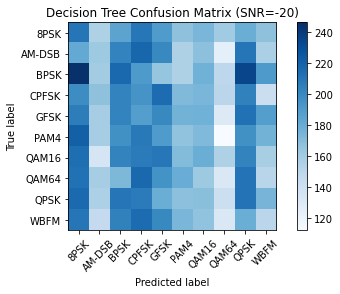

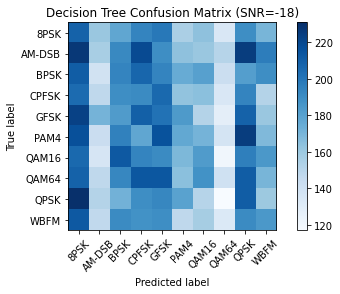

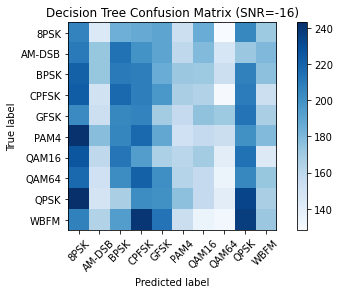

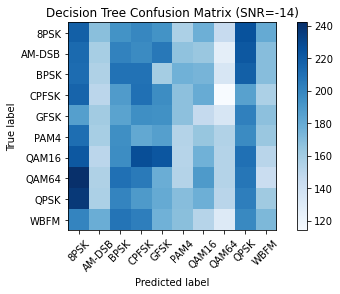

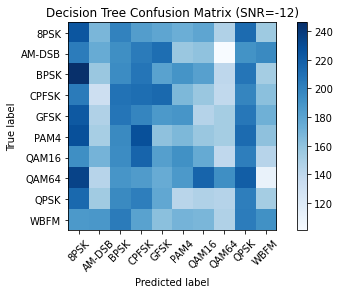

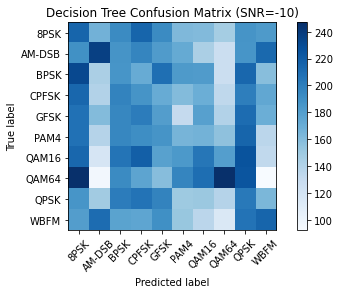

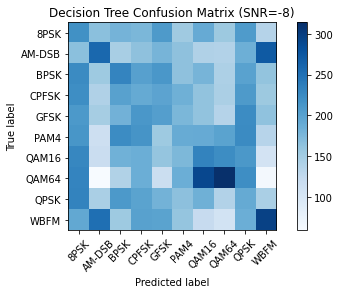

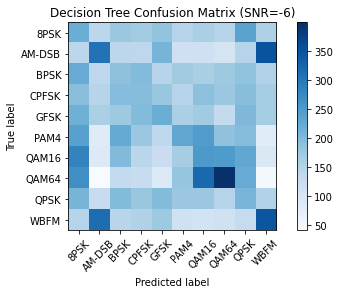

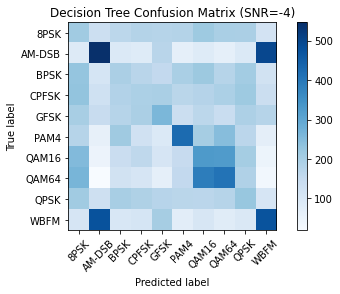

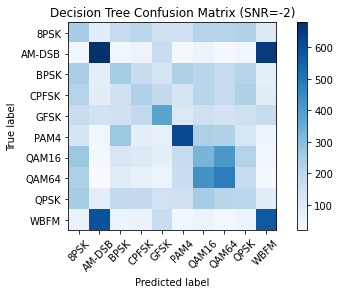

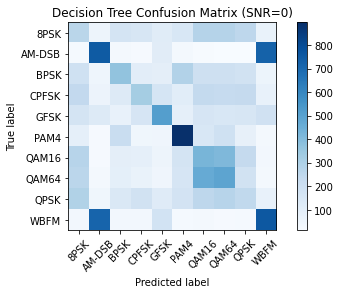

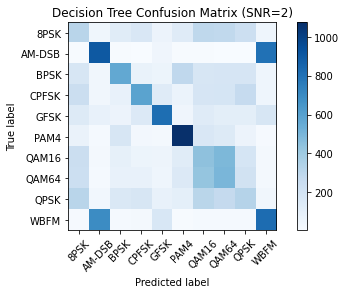

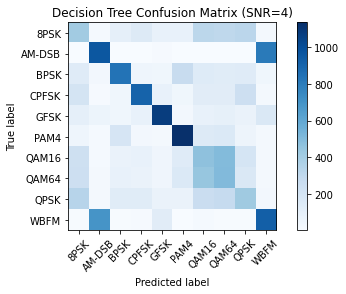

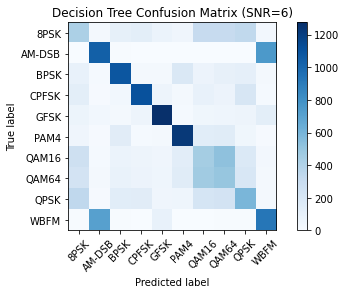

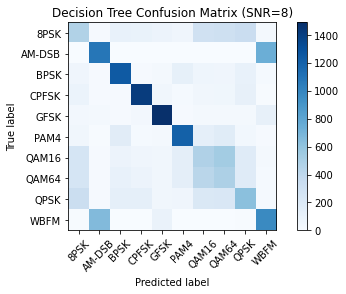

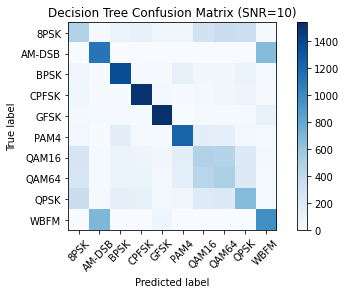

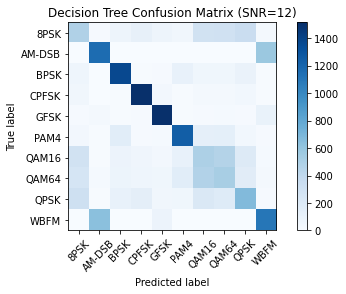

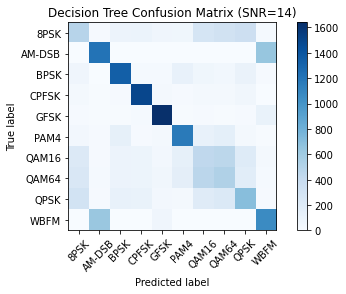

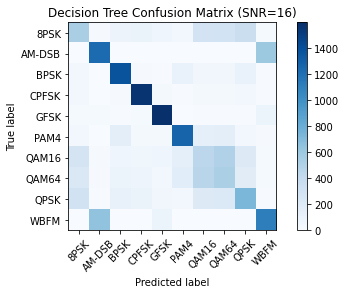

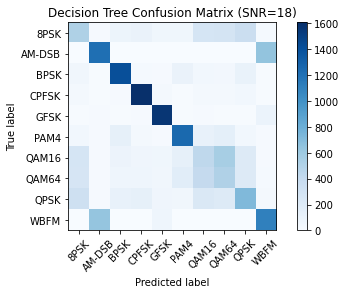

In [ ]:
acc = []
tr_acc = []
val_acc = []
for snr in snrs:
  print("SNR = ", snr)
  #test accuracy
  X_test_i = X_test[np.where(testY_snr == str(snr))]
  testY_mods_i = testY_mods[np.where(testY_snr == str(snr))]

  y_pred = decision_tree_model.predict(X_test_i)
  accuracy = accuracy_score(y_pred, testY_mods_i)
  acc.append(accuracy)
  print("\nAccuracy = ", accuracy)

  #train accuracy
  X_train_i = X_train[np.where(trainY_snr == str(snr))]
  trainY_mods_i = trainY_mods[np.where(trainY_snr == str(snr))]

  y_pred_train = decision_tree_model.predict(X_train_i)
  train_accuracy = accuracy_score(y_pred_train, trainY_mods_i)
  tr_acc.append(train_accuracy)
  print("Train Accuracy = ", train_accuracy)

  #validation accuracy
  X_val_i = X_val[np.where(valY_snr == str(snr))]
  valY_mods_i = valY_mods[np.where(valY_snr == str(snr))]

  y_pred_val = decision_tree_model.predict(X_val_i)
  val_accuracy = accuracy_score(y_pred_val, valY_mods_i)
  val_acc.append(val_accuracy)
  print("Validation Accuracy = ", val_accuracy)

  conf = confusion_matrix(testY_mods_i, y_pred)
  plt.figure()
  plot_confusion_matrix(conf, labels=mods, title="Decision Tree Confusion Matrix (SNR=%d)"%(snr))

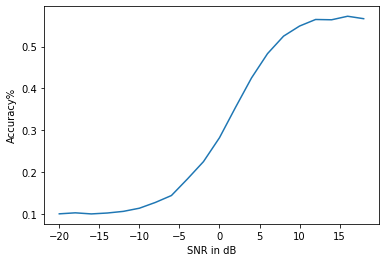

In [ ]:
# Plot the data
plt.plot(snrs, acc)
plt.xlabel('SNR in dB')
plt.ylabel('Accuracy%')
# Show the plot
plt.show()

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators = 50, n_jobs=1)
random_forest_model = random_forest.fit(X_train, trainY_mods)

In [ ]:
import pickle
pickle.dump(random_forest_model, open(f'/content/drive/MyDrive/College/Data_Mining_Assignments/Modulation_classification/models/random_forest.sav', 'wb'))

# random_forest_model = pickle.load(open(f'/content/drive/MyDrive/College/Data_Mining_Assignments/Modulation_classification/models/random_forest.sav', 'rb'))

SNR =  -20

Accuracy =  0.09869943789264851
Train Accuracy =  1.0
Validation Accuracy =  0.10119904076738609
SNR =  -18

Accuracy =  0.10486246179494305
Train Accuracy =  1.0
Validation Accuracy =  0.09792147806004618
SNR =  -16

Accuracy =  0.10448742534655635
Train Accuracy =  1.0
Validation Accuracy =  0.1062618595825427
SNR =  -14

Accuracy =  0.11079718575148191
Train Accuracy =  1.0
Validation Accuracy =  0.09581963363081258
SNR =  -12

Accuracy =  0.11735144687430969
Train Accuracy =  1.0
Validation Accuracy =  0.11929307805596466
SNR =  -10

Accuracy =  0.13801749596032764
Train Accuracy =  1.0
Validation Accuracy =  0.13882240306366683
SNR =  -8

Accuracy =  0.18084639842122574
Train Accuracy =  1.0
Validation Accuracy =  0.17306823316764572
SNR =  -6

Accuracy =  0.24915919282511212
Train Accuracy =  1.0
Validation Accuracy =  0.2537174721189591
SNR =  -4

Accuracy =  0.31446540880503143
Train Accuracy =  1.0
Validation Accuracy =  0.31105651105651105
SNR =  -2

Accuracy =  0

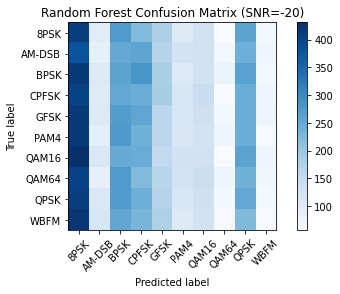

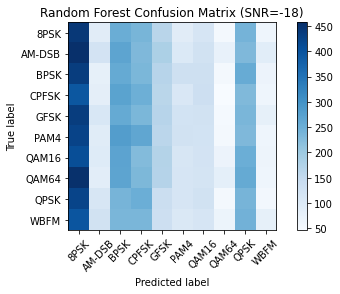

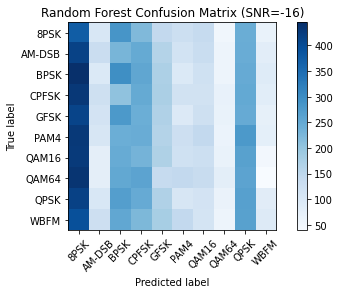

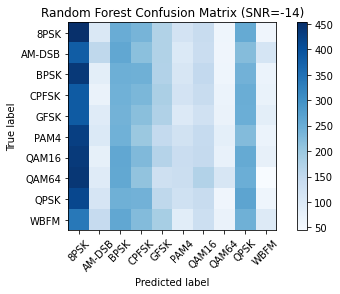

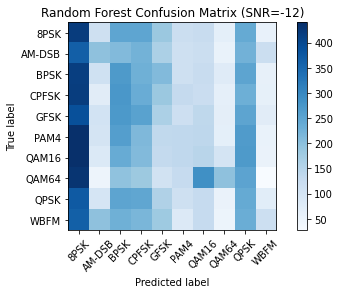

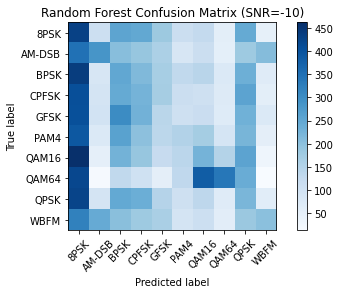

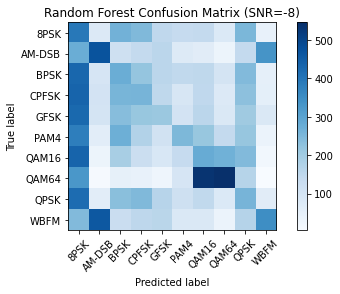

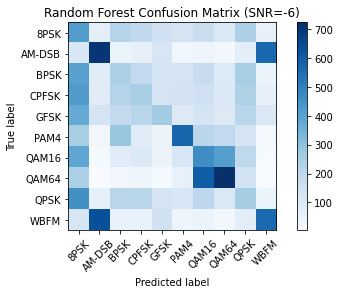

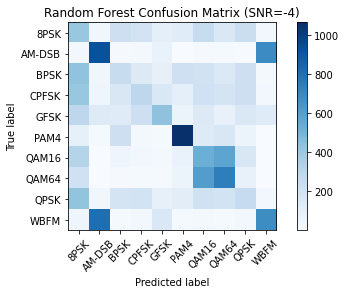

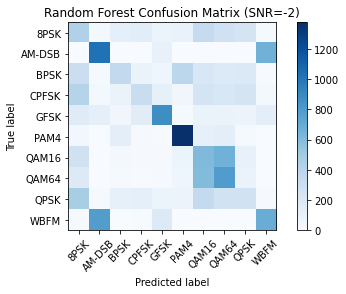

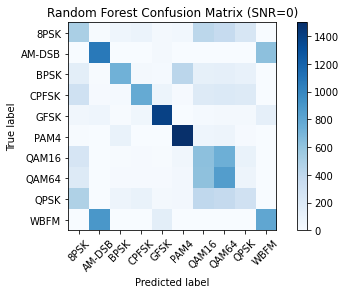

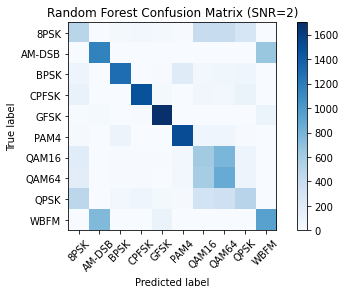

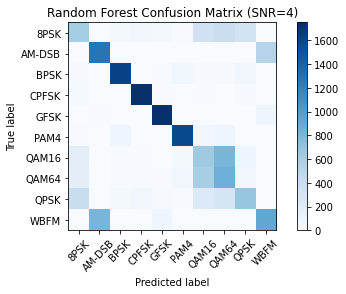

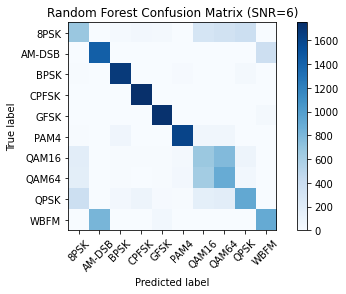

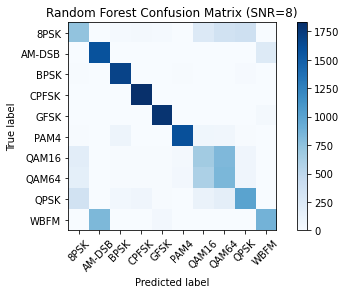

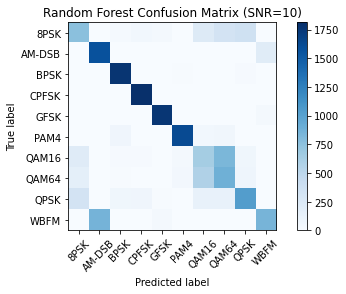

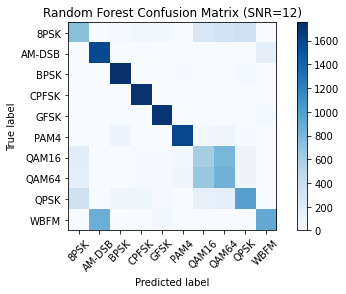

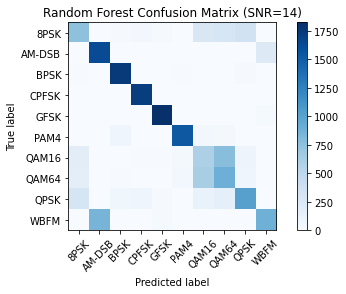

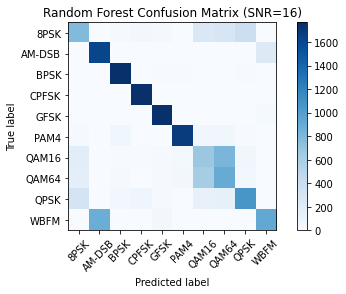

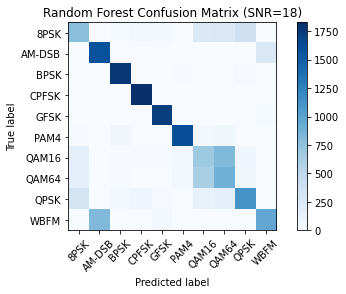

In [ ]:
acc = []
tr_acc = []
val_acc = []
for snr in snrs:
  print("SNR = ", snr)
  #test accuracy
  X_test_i = X_test[np.where(testY_snr == str(snr))]
  testY_mods_i = testY_mods[np.where(testY_snr == str(snr))]

  y_pred = random_forest_model.predict(X_test_i)
  accuracy = accuracy_score(y_pred, testY_mods_i)
  acc.append(accuracy)
  print("\nAccuracy = ", accuracy)

  #train accuracy
  X_train_i = X_train[np.where(trainY_snr == str(snr))]
  trainY_mods_i = trainY_mods[np.where(trainY_snr == str(snr))]

  y_pred_train = random_forest_model.predict(X_train_i)
  train_accuracy = accuracy_score(y_pred_train, trainY_mods_i)
  tr_acc.append(train_accuracy)
  print("Train Accuracy = ", train_accuracy)

  #validation accuracy
  X_val_i = X_val[np.where(valY_snr == str(snr))]
  valY_mods_i = valY_mods[np.where(valY_snr == str(snr))]

  y_pred_val = random_forest_model.predict(X_val_i)
  val_accuracy = accuracy_score(y_pred_val, valY_mods_i)
  val_acc.append(val_accuracy)
  print("Validation Accuracy = ", val_accuracy)

  conf = confusion_matrix(testY_mods_i, y_pred)
  plt.figure()
  plot_confusion_matrix(conf, labels=mods, title="Random Forest Confusion Matrix (SNR=%d)"%(snr))

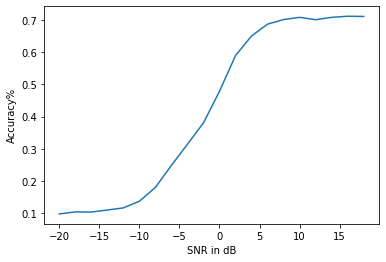

In [ ]:
# Plot the data
plt.plot(snrs, acc)
plt.xlabel('SNR in dB')
plt.ylabel('Accuracy%')
# Show the plot
plt.show()

In [ ]:
print("trainX.shape", trainX.shape)
print("testX.shape", testX.shape)
print("valX.shape", valX.shape)
print("trainy.shape", trainY.shape)
print("testy.shape", testY.shape)
print("valy.shape", valY.shape)

trainX.shape (798000, 2, 128)
testX.shape (360000, 2, 128)
valX.shape (42000, 2, 128)
trainy.shape (798000, 2)
testy.shape (360000, 2)
valy.shape (42000, 2)


# Start

**Get features**

In [5]:
def getFeatures(version): # 1, 2, 3 or 4
  if (version == 1):
      # X_raw = X[:,0], X[:,1]
      # X_raw = np.asarray(X_raw)
      return X
  elif (version == 2):
      X_der = np.apply_along_axis(lambda column:np.gradient(column),2,X)
      X_der = np.asarray(X_der)  
      return X_der
  elif (version == 3):
      X_int = np.apply_along_axis(lambda column:np.hstack((0,column)),2,np.apply_along_axis(lambda column:sp.integrate.cumtrapz(column,dx=1,axis=-1),2,X))
      X_int = np.asarray(X_int)  
      return X_int
  elif (version == 4):
      com_three_X = np.concatenate((np.apply_along_axis(lambda column:np.gradient(column),2,X) ,np.apply_along_axis(lambda column:np.hstack((0,column)),2,np.apply_along_axis(lambda column:sp.integrate.cumtrapz(column,dx=1,axis=-1),2,X))),axis=1)
      print(com_three_X.shape)
      com_three_X = np.asarray(com_three_X)
      print(com_three_X.shape)
      return com_three_X
  else :
      print("Error:this version doesn't exist")
      return X


**Splitting Data**

In [6]:
def split_data(XIn,YIn):
  Y = np.array(YIn)
  (trainX, testX, trainY, testY) = train_test_split(XIn,Y, test_size=0.3)
  (trainX, valX, trainY, valY) = train_test_split(trainX,trainY, test_size=0.05)

  lb = preprocessing.LabelBinarizer()
  trainY_mods, trainY_snr = zip(*trainY)
  testY_mods, testY_snr = zip(*testY)
  valY_mods, valY_snr = zip(*valY)

  trainY_mods = np.array(trainY_mods)
  trainY_mod10 = lb.fit_transform(trainY_mods)

  trainY_snr = np.array(trainY_snr)
  testY_mods = np.array(testY_mods)
  testY_mod10 = lb.fit_transform(testY_mods)
  testY_snr = np.array(testY_snr)
  valY_mods = np.array(valY_mods)
  valY_mod10 = lb.fit_transform(valY_mods)
  valY_snr = np.array(valY_snr)

  return trainX, trainY_snr, trainY_mods, trainY_mod10, valX, valY_snr, valY_mods, valY_mod10, testX, testY_snr, testY_mods, testY_mod10

**Flatten Data**

In [7]:
def flatten(trainX, testX, valX):
  
  nsamples, nx, ny = trainX.shape
  X_train = trainX.reshape((nsamples,nx*ny))

  nsamples, nx, ny = testX.shape
  X_test = testX.reshape((nsamples,nx*ny))

  nsamples, nx, ny = valX.shape
  X_val = valX.reshape((nsamples,nx*ny))

  return X_train, X_test, X_val

In [8]:
# change the number for the data you want 1, 2 or 3
trainX, trainY_snr, trainY_mods, trainY_mod10, valX, valY_snr, valY_mods, valY_mod10, testX, testY_snr, testY_mods, testY_mod10 = split_data(getFeatures(2),lbl)
X_train, X_test, X_val = flatten(trainX, testX, valX)


# Functions

**Confusion Matrix plotting**

In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(labels))
  plt.xticks(tick_marks, labels, rotation=45)
  plt.yticks(tick_marks, labels)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

**SNRs Plotting**

In [10]:
def snr_plot(acc, snrs):
  # Plot the data
  plt.plot(snrs, acc)
  plt.xlabel('SNR in dB')
  plt.ylabel('Accuracy%')
  # Show the plot
  plt.show()


**Calculating accuracy for each snr**

In [11]:
def calculatingAcc(model,Xtr,Xte,Xva,shape):
  acc = []
  tr_acc = []
  val_acc = []
  for snr in snrs:
    print("\nSNR = ", snr)
    #test accuracy
    normalized_X_test_i = Xte[np.where(testY_snr == str(snr))]
    testY_mods_i = testY_mods[np.where(testY_snr == str(snr))]
    trainY_mods_i = trainY_mods[np.where(trainY_snr == str(snr))]
    valY_mods_i = valY_mods[np.where(valY_snr == str(snr))]
    y_pred = model.predict(normalized_X_test_i)
    if (shape == 10):
        testY_mods_i = testY_mod10[np.where(testY_snr == str(snr))]
        trainY_mods_i = trainY_mod10[np.where(trainY_snr == str(snr))]
        valY_mods_i = valY_mod10[np.where(valY_snr == str(snr))]
        testY_mods_i = np.argmax(testY_mods_i, axis=1)
        y_pred = np.argmax(y_pred, axis=1)

    accuracy = accuracy_score(y_pred, testY_mods_i)
    acc.append(accuracy)
    print("Accuracy = ", accuracy)

    #train accuracy
    normalized_X_train_i = Xtr[np.where(trainY_snr == str(snr))]
    y_pred_train = model.predict(normalized_X_train_i)

    if (shape == 10):
      trainY_mods_i = np.argmax(trainY_mods_i, axis=1)
      y_pred_train = np.argmax(y_pred_train, axis=1)

    train_accuracy = accuracy_score(y_pred_train, trainY_mods_i)
    tr_acc.append(train_accuracy)
    print("Train Accuracy = ", train_accuracy)

    #validation accuracy
    X_val_i = Xva[np.where(valY_snr == str(snr))]
    y_pred_val = model.predict(X_val_i)

    if (shape == 10):
      valY_mods_i = np.argmax(valY_mods_i, axis=1)
      y_pred_val = np.argmax(y_pred_val, axis=1)

    val_accuracy = accuracy_score(y_pred_val, valY_mods_i)
    val_acc.append(val_accuracy)
    print("Validation Accuracy = ", val_accuracy)
    print("Avarege Overall Accuracy = ", (val_accuracy+train_accuracy+accuracy)/3)
    conf = confusion_matrix(testY_mods_i, y_pred)
    plt.figure()
    plot_confusion_matrix(conf, labels=mods, title="Confusion Matrix (SNR=%d)"%(snr))
  return acc

# **Functions of Classifiers**

**Logistic Regression**

In [12]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
import pickle

def log_reg_classifier(snrs, mods, X_train, X_test, X_val, trainY_mods, testY_mods, valY_mods, trainY_snr, testY_snr, valY_snr):  
  
  #logistic regression classifier
  logistic_regression = LogisticRegression(max_iter=1000)
  scaler = MinMaxScaler()
  normalized_X_train = scaler.fit_transform(X_train)
  normalized_X_test = scaler.transform(X_test)
  normalized_X_val = scaler.transform(X_val)
  logistic_regression_model = logistic_regression.fit(normalized_X_train, trainY_mods)

  #save model
  # pickle.dump(logistic_regression_model, open(f'/content/drive/MyDrive/College/Data_Mining_Assignments/Modulation_classification/models/logistic_regression(feature_typexxxx).sav', 'wb'))

  acc = calculatingAcc(logistic_regression_model,normalized_X_train,normalized_X_test,normalized_X_val,0)
  return acc

**Decision Tree**

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import pickle

def decision_tree_classifier(snrs, mods, X_train, X_test, X_val, trainY_mods, testY_mods, valY_mods, trainY_snr, testY_snr, valY_snr):

  #Decision Tree classifier
  decision_tree = DecisionTreeClassifier()
  decision_tree_model = decision_tree.fit(X_train, trainY_mods)

  #save model
  # pickle.dump(decision_tree_model, open(f'/content/drive/MyDrive/College/Data_Mining_Assignments/Modulation_classification/models/decision_tree(feature_typexxxx).sav', 'wb'))

  acc = calculatingAcc(decision_tree_model,X_train,X_test,X_val,0)
  return acc

**Random Forest**

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import pickle

def random_forest_classifier(snrs, mods, X_train, X_test, X_val, trainY_mods, testY_mods, valY_mods, trainY_snr, testY_snr, valY_snr):

  #random forest classifier
  random_forest = RandomForestClassifier(n_estimators = 50, n_jobs=1)
  random_forest_model = random_forest.fit(X_train, trainY_mods)

  #save model
  # pickle.dump(decision_tree_model, open(f'/content/drive/MyDrive/College/Data_Mining_Assignments/Modulation_classification/models/random_forest(feature_typexxxx).sav', 'wb'))

  acc = calculatingAcc(random_forest_model,X_train,X_test,X_val,0)
  return acc

**Fully Connetced Dense Layer**

In [15]:
def full_dense(X_train, trainY_mod10, X_val, valY_mod10, X_test):

  in_shp = list(X_train.shape[1:])
  model = models.Sequential()
  model.add(Dense(128, activation ='relu', input_shape = in_shp))
  model.add(Flatten())
  model.add(Dense(10, activation ='softmax'))

  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',  metrics = ['accuracy'])

  print("Model summary for this input: ")  
  model.summary()
  
  nb_epoch = 100     # number of epochs to train on
  batch_size = 1024  # training batch size
  
  print("Start training for model: ")
  history = model.fit(X_train,
      trainY_mod10,
      batch_size = batch_size,
      epochs = nb_epoch,
      verbose = 2,
      validation_data = (X_val, valY_mod10),
      callbacks = [
          keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
          keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
      ])
  print("Training End")

  plt.figure(1)
  plt.title('Training performance')
  plt.plot(history.epoch, history.history['loss'], label='train loss+error')
  plt.plot(history.epoch, history.history['val_loss'], label='val_error')
  plt.legend()

  plt.figure(2)
  acc = calculatingAcc(model, X_train, X_test, X_val, 10)
  snr_plot(acc, snrs)

**CNN Model**

**Function to create model**

In [16]:

def CnnModel(X_trainIn,Y_trainIn,X_valIn,Y_valIn,X_testIn,Y_testIn):
  in_shp = list(X_trainIn.shape[1:])
  dr = 0.5
  # [(W−K+2P)/S]+1
  model = models.Sequential()
  # input 2 * 128
  model.add(Reshape([1]+in_shp, input_shape=in_shp))
  # model.add(ZeroPadding2D((0, 2)))
  # ConvLayer1 64 * 1 * 3
  model.add(Conv2D(64, (1, 3), activation="relu", name="conv1",  padding="valid",data_format = 'channels_first', kernel_initializer="glorot_uniform"))
  model.add(Dropout(dr))
  # model.add(ZeroPadding2D((0, 2)))
  # ConvLayer2 16 * 2 * 3
  model.add(Conv2D(16, (2, 3), activation="relu", name="conv2", padding="valid",data_format = 'channels_first',  kernel_initializer="glorot_uniform"))
  model.add(Dropout(dr))
  model.add(Flatten())
  # Dense Layer 128
  model.add(Dense(128, activation="relu", name="dense1", kernel_initializer="he_normal"))
  model.add(Dropout(dr))
  # Dense Layer 10
  model.add(Dense(10,activation='softmax', name="dense2", kernel_initializer="he_normal"))
  model.compile(loss='categorical_crossentropy', optimizer='adam')
  model.build(X_trainIn.shape) 
  print("Model summary for this input: ")                         
  model.summary()
  nb_epoch = 100     # number of epochs to train on
  batch_size = 1024  # training batch size
  filepath = 'models/cnnmodel.h5'
  print("Start training for model: ")
  history = model.fit(X_trainIn,
      Y_trainIn,
      batch_size=batch_size,
      epochs=nb_epoch,
      verbose=2,
      validation_data=(X_valIn, Y_valIn),
      callbacks = [
          keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
          keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
      ])
  model.load_weights(filepath)
  print("Training End")
  print("Scores :")
  score1 = model.evaluate(X_trainIn, Y_trainIn, verbose=0, batch_size=batch_size)
  score2 = model.evaluate(X_valIn, Y_valIn, verbose=0, batch_size=batch_size)
  score3 = model.evaluate(X_testIn, Y_testIn, verbose=0, batch_size=batch_size)
  print("Train = ",score1)
  print("Validation = ",score2)
  print("Test = ",score3)
  print("Trainig Performance :")
  plt.figure(1)
  plt.title('Training performance')
  plt.plot(history.epoch, history.history['loss'], label='train loss+error')
  plt.plot(history.epoch, history.history['val_loss'], label='val_error')
  plt.legend()
  plt.figure(2)
  acc = calculatingAcc(model,X_trainIn,X_testIn,X_valIn,10)
  snr_plot(acc, snrs)
  return

# **Training Classifiers**

In [17]:
# delete X you work on and collect garbage
del(X)
gc.collect()

0

In [ ]:
# # trainX, testX, valX, trainY_mods, testY_mods, valY_mods, trainY_snr, testY_snr, valY_snr = split_data(com_three_X, lbl)
# trainX, trainY_snr, trainY_mods, trainY_mod10, valX, valY_snr, valY_mods, valY_mod10, testX, testY_snr, testY_mods, testY_mod10 = getSplitedData(getFeatures(2),lbl)
# X_train, X_test, X_val = flatten(trainX, testX, valX)



SNR =  -20
Accuracy =  0.09881575323602314
Train Accuracy =  0.11398807277119348
Validation Accuracy =  0.10551330798479087
Avarege Overall Accuracy =  0.10610571133066916


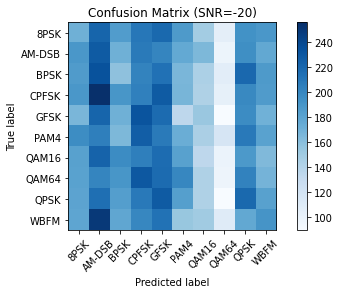


SNR =  -18
Accuracy =  0.09907068431427767
Train Accuracy =  0.1131337782647674
Validation Accuracy =  0.09909047391096218
Avarege Overall Accuracy =  0.10376497883000242


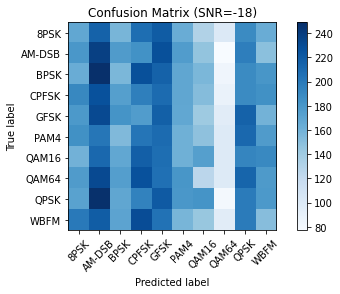


SNR =  -16
Accuracy =  0.10289157958754906
Train Accuracy =  0.11602390278196244
Validation Accuracy =  0.10551558752997602
Avarege Overall Accuracy =  0.10814368996649583


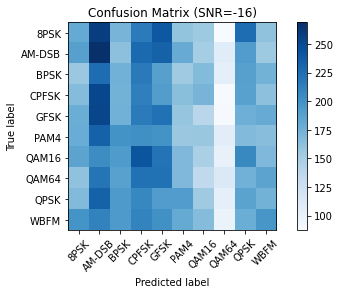


SNR =  -14
Accuracy =  0.1009239907600924
Train Accuracy =  0.11078922840516915
Validation Accuracy =  0.09806694955209806
Avarege Overall Accuracy =  0.10326005623911987


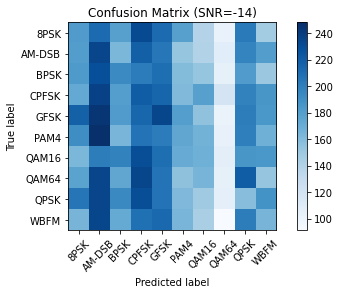


SNR =  -12
Accuracy =  0.09835155686296276
Train Accuracy =  0.11364263668983514
Validation Accuracy =  0.09436619718309859
Avarege Overall Accuracy =  0.10212013024529883


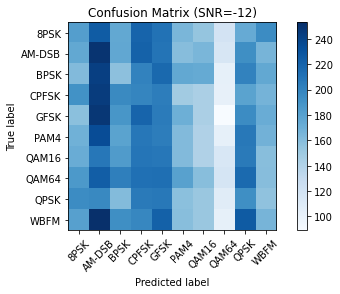


SNR =  -10
Accuracy =  0.09956157389422277
Train Accuracy =  0.1128053368109545
Validation Accuracy =  0.10393925011865211
Avarege Overall Accuracy =  0.10543538694127647


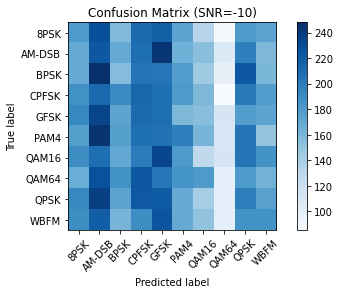


SNR =  -8
Accuracy =  0.10133790358248562
Train Accuracy =  0.1133929918053391
Validation Accuracy =  0.10892018779342723
Avarege Overall Accuracy =  0.10788369439375066


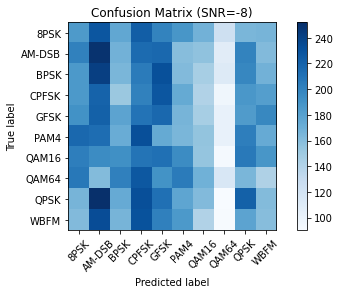


SNR =  -6
Accuracy =  0.10249972101327977
Train Accuracy =  0.11545395362812359
Validation Accuracy =  0.10607476635514018
Avarege Overall Accuracy =  0.10800948033218118


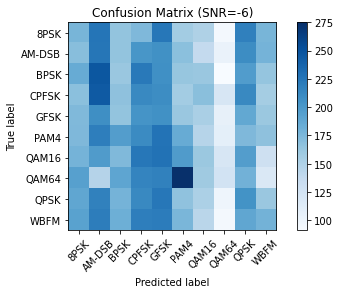


SNR =  -4
Accuracy =  0.10815363881401617
Train Accuracy =  0.11516118576878008
Validation Accuracy =  0.10177628420547287
Avarege Overall Accuracy =  0.10836370292942304


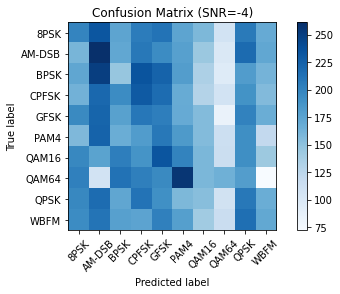


SNR =  -2
Accuracy =  0.10778708997058334
Train Accuracy =  0.11944785429766766
Validation Accuracy =  0.11374636979670862
Avarege Overall Accuracy =  0.11366043802165321


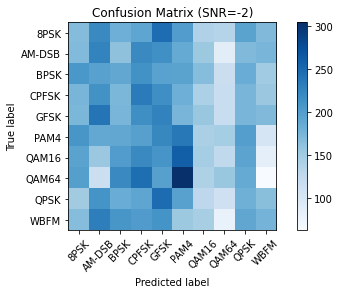


SNR =  0
Accuracy =  0.11215629522431259
Train Accuracy =  0.1169967410378541
Validation Accuracy =  0.11240671641791045
Avarege Overall Accuracy =  0.11385325089335903


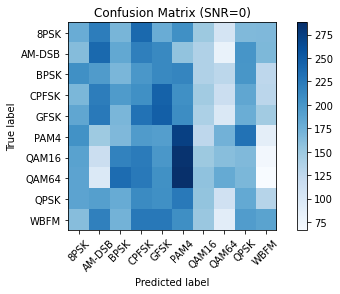


SNR =  2
Accuracy =  0.11512866015971605
Train Accuracy =  0.12057627629135084
Validation Accuracy =  0.12041392285983067
Avarege Overall Accuracy =  0.11870628643696586


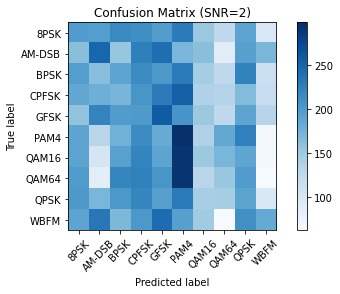


SNR =  4
Accuracy =  0.11505940867642996
Train Accuracy =  0.1221617281782372
Validation Accuracy =  0.11962890625
Avarege Overall Accuracy =  0.11895001436822239


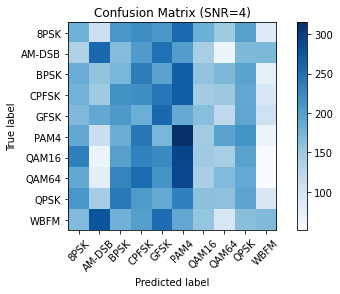


SNR =  6
Accuracy =  0.12472271517302573
Train Accuracy =  0.12509087262791105
Validation Accuracy =  0.1189215214251324
Avarege Overall Accuracy =  0.12291170307535638


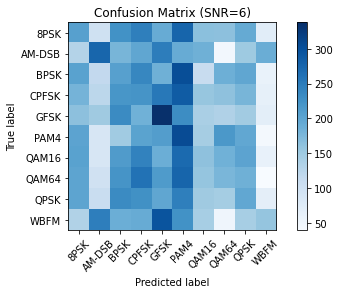


SNR =  8
Accuracy =  0.12838968865082023
Train Accuracy =  0.1281351689612015
Validation Accuracy =  0.10949248120300752
Avarege Overall Accuracy =  0.12200577960500975


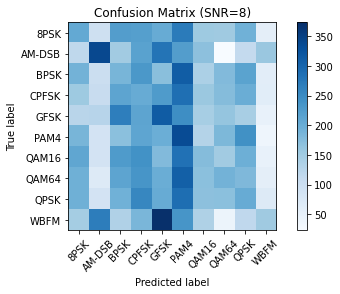


SNR =  10
Accuracy =  0.1281241341091715
Train Accuracy =  0.13071944611679712
Validation Accuracy =  0.13821138211382114
Avarege Overall Accuracy =  0.13235165411326325


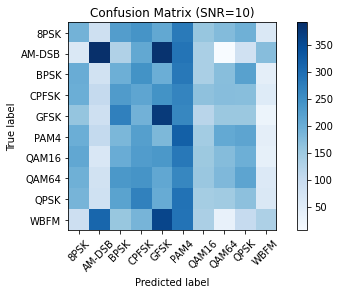


SNR =  12
Accuracy =  0.13290998217468805
Train Accuracy =  0.13542968554716792
Validation Accuracy =  0.12291870714985309
Avarege Overall Accuracy =  0.1304194582905697


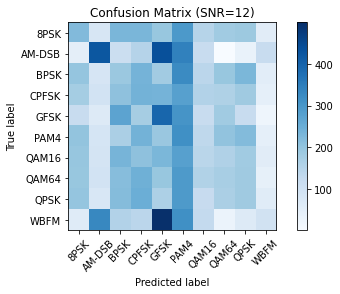


SNR =  14
Accuracy =  0.13083333333333333
Train Accuracy =  0.13945331095131913
Validation Accuracy =  0.12649736463823671
Avarege Overall Accuracy =  0.13226133630762973


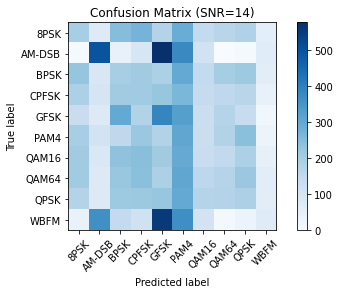


SNR =  16
Accuracy =  0.13748807987883546
Train Accuracy =  0.13837781161844373
Validation Accuracy =  0.13657844990548204
Avarege Overall Accuracy =  0.13748144713425373


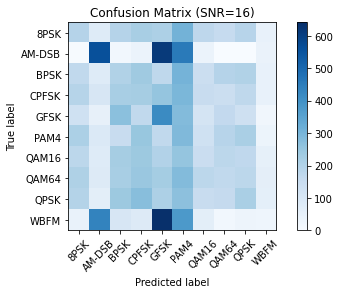


SNR =  18
Accuracy =  0.13529509375518559
Train Accuracy =  0.1347558679553157
Validation Accuracy =  0.1289549376797699
Avarege Overall Accuracy =  0.13300196646342374


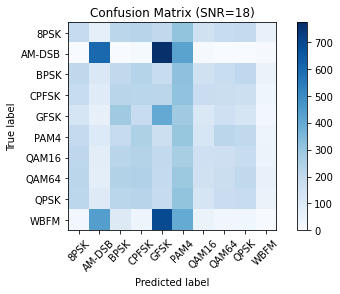

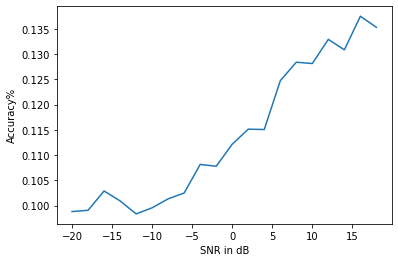

In [18]:
acc = log_reg_classifier(snrs, mods, X_train, X_test, X_val, trainY_mods, testY_mods, valY_mods, trainY_snr, testY_snr, valY_snr)
snr_plot(acc, snrs)


SNR =  -20
Accuracy =  0.10101900302946847
Train Accuracy =  1.0
Validation Accuracy =  0.09980988593155894
Avarege Overall Accuracy =  0.4002762963203425


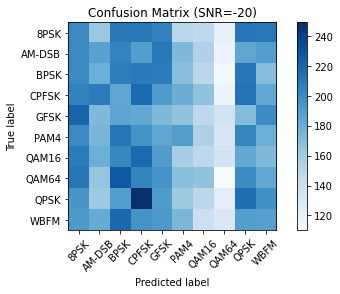


SNR =  -18
Accuracy =  0.10306955787102225
Train Accuracy =  1.0
Validation Accuracy =  0.10914313068453806
Avarege Overall Accuracy =  0.4040708961851868


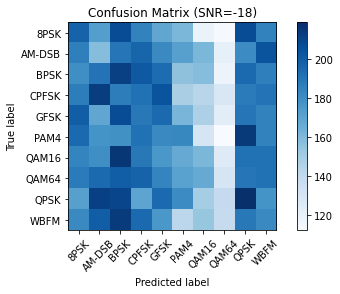


SNR =  -16
Accuracy =  0.10095648808536518
Train Accuracy =  1.0
Validation Accuracy =  0.09448441247002398
Avarege Overall Accuracy =  0.39848030018512975


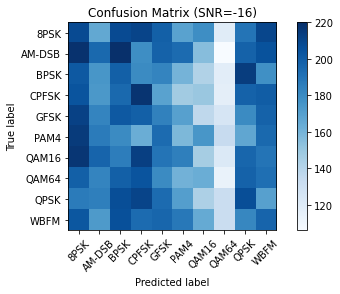


SNR =  -14
Accuracy =  0.0998240017599824
Train Accuracy =  1.0
Validation Accuracy =  0.09618104667609619
Avarege Overall Accuracy =  0.3986683494786929


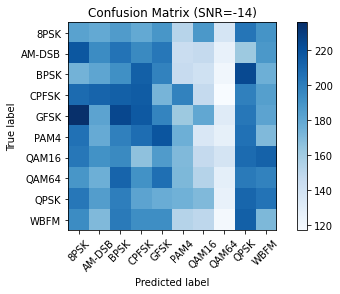


SNR =  -12
Accuracy =  0.1012932230671033
Train Accuracy =  1.0
Validation Accuracy =  0.09624413145539906
Avarege Overall Accuracy =  0.39917911817416746


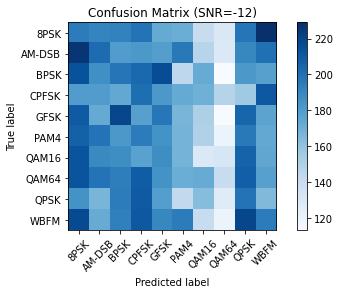


SNR =  -10
Accuracy =  0.1007270103779344
Train Accuracy =  1.0
Validation Accuracy =  0.10299003322259136
Avarege Overall Accuracy =  0.4012390145335085


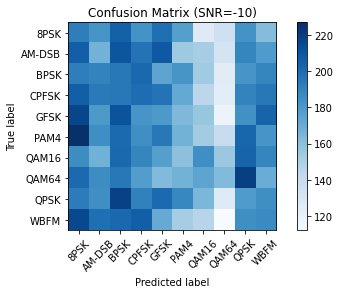


SNR =  -8
Accuracy =  0.10349402919062362
Train Accuracy =  1.0
Validation Accuracy =  0.10422535211267606
Avarege Overall Accuracy =  0.40257312710109994


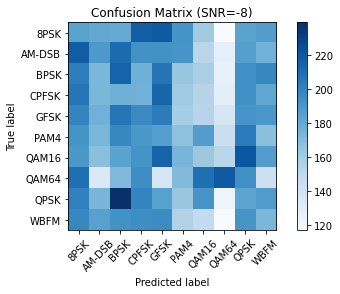


SNR =  -6
Accuracy =  0.11086932262024328
Train Accuracy =  1.0
Validation Accuracy =  0.10514018691588785
Avarege Overall Accuracy =  0.4053365031787104


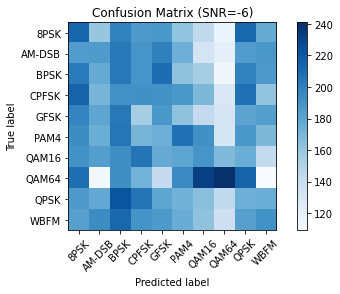


SNR =  -4
Accuracy =  0.11859838274932614
Train Accuracy =  1.0
Validation Accuracy =  0.10465674507921267
Avarege Overall Accuracy =  0.4077517092761796


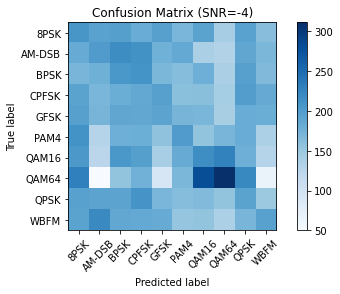


SNR =  -2
Accuracy =  0.12382749625353832
Train Accuracy =  1.0
Validation Accuracy =  0.1185866408518877
Avarege Overall Accuracy =  0.4141380457018087


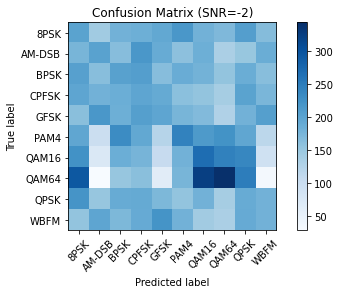


SNR =  0
Accuracy =  0.15106311922520316
Train Accuracy =  1.0
Validation Accuracy =  0.13992537313432835
Avarege Overall Accuracy =  0.4303294974531772


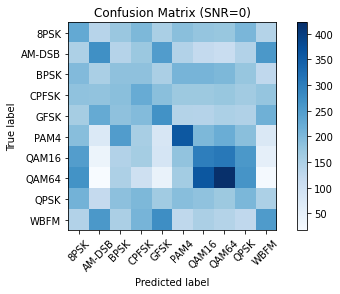


SNR =  2
Accuracy =  0.17729591836734693
Train Accuracy =  1.0
Validation Accuracy =  0.187206020696143
Avarege Overall Accuracy =  0.45483397968782996


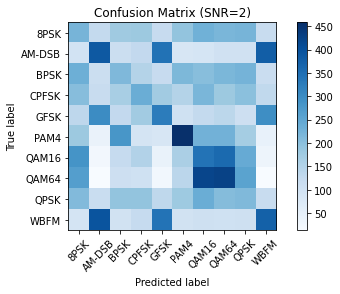


SNR =  4
Accuracy =  0.22326609560652114
Train Accuracy =  1.0
Validation Accuracy =  0.22607421875
Avarege Overall Accuracy =  0.4831134381188404


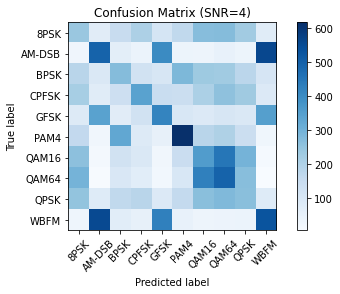


SNR =  6
Accuracy =  0.28748890860692106
Train Accuracy =  1.0
Validation Accuracy =  0.294174289841117
Avarege Overall Accuracy =  0.527221066149346


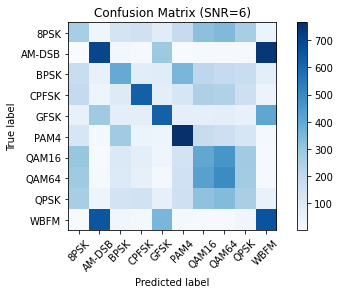


SNR =  8
Accuracy =  0.3645798459993304
Train Accuracy =  1.0
Validation Accuracy =  0.3815789473684211
Avarege Overall Accuracy =  0.5820529311225838


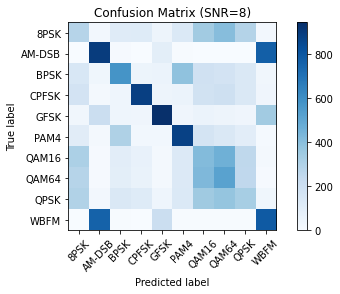


SNR =  10
Accuracy =  0.4251039068994181
Train Accuracy =  1.0
Validation Accuracy =  0.4170253467240555
Avarege Overall Accuracy =  0.6140430845411579


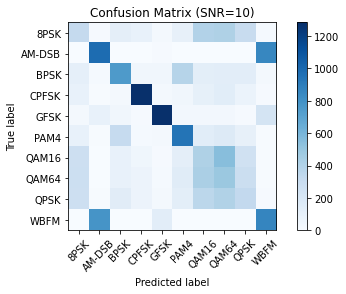


SNR =  12
Accuracy =  0.4716466131907308
Train Accuracy =  1.0
Validation Accuracy =  0.46131243878550443
Avarege Overall Accuracy =  0.6443196839920784


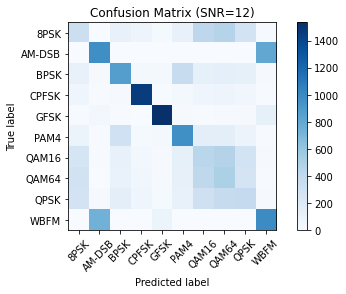


SNR =  14
Accuracy =  0.48833333333333334
Train Accuracy =  1.0
Validation Accuracy =  0.46478198370867274
Avarege Overall Accuracy =  0.6510384390140019


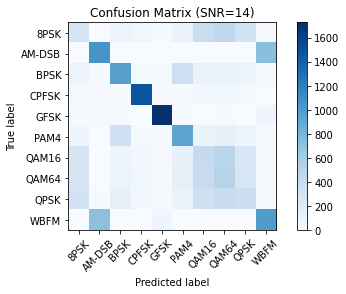


SNR =  16
Accuracy =  0.4957087563807707
Train Accuracy =  1.0
Validation Accuracy =  0.4948015122873346
Avarege Overall Accuracy =  0.6635034228893685


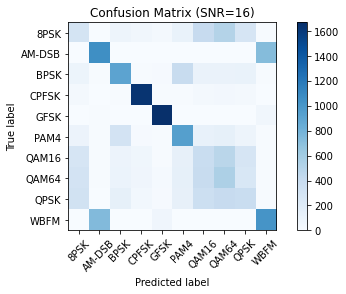


SNR =  18
Accuracy =  0.5087117650312517
Train Accuracy =  1.0
Validation Accuracy =  0.49760306807286675
Avarege Overall Accuracy =  0.6687716110347061


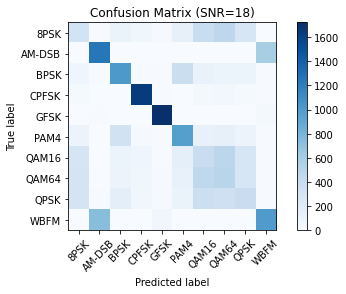

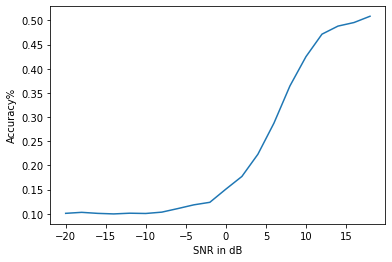

In [19]:
acc = decision_tree_classifier(snrs, mods, X_train, X_test, X_val, trainY_mods, testY_mods, valY_mods, trainY_snr, testY_snr, valY_snr)
snr_plot(acc, snrs)


SNR =  -20
Accuracy =  0.097934453318645
Train Accuracy =  1.0
Validation Accuracy =  0.10646387832699619
Avarege Overall Accuracy =  0.4014661105485471


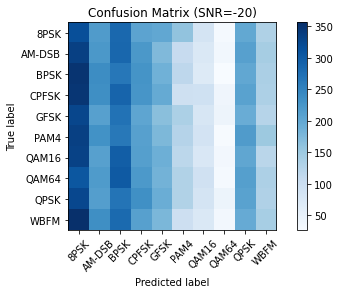


SNR =  -18
Accuracy =  0.10025344973246973
Train Accuracy =  1.0
Validation Accuracy =  0.1086644327429392
Avarege Overall Accuracy =  0.4029726274918029


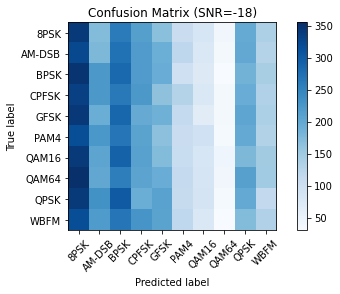


SNR =  -16
Accuracy =  0.0994637032122519
Train Accuracy =  1.0
Validation Accuracy =  0.1093525179856115
Avarege Overall Accuracy =  0.40293874039928773


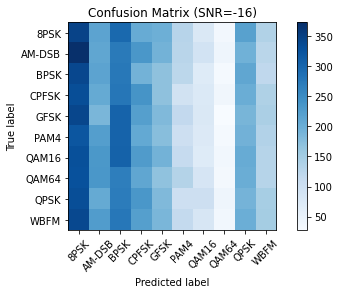


SNR =  -14
Accuracy =  0.0956440435595644
Train Accuracy =  1.0
Validation Accuracy =  0.10513908533710514
Avarege Overall Accuracy =  0.4002610429655566


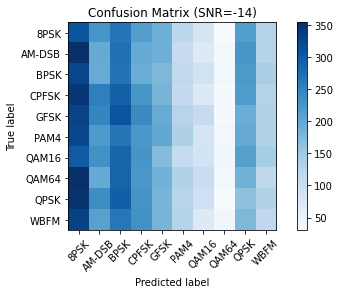


SNR =  -12
Accuracy =  0.0982405505911084
Train Accuracy =  1.0
Validation Accuracy =  0.10140845070422536
Avarege Overall Accuracy =  0.39988300043177794


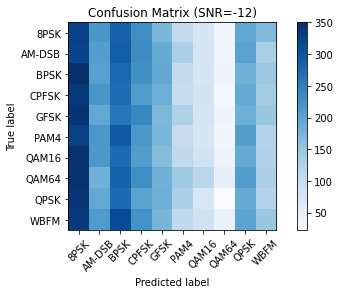


SNR =  -10
Accuracy =  0.10583273211609967
Train Accuracy =  1.0
Validation Accuracy =  0.11058376839107736
Avarege Overall Accuracy =  0.4054721668357257


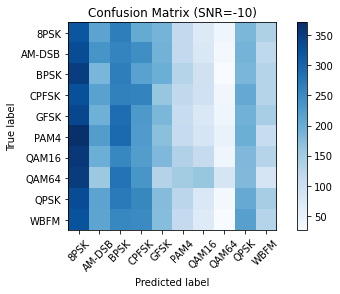


SNR =  -8
Accuracy =  0.11305838124723573
Train Accuracy =  1.0
Validation Accuracy =  0.12065727699530517
Avarege Overall Accuracy =  0.4112385527475136


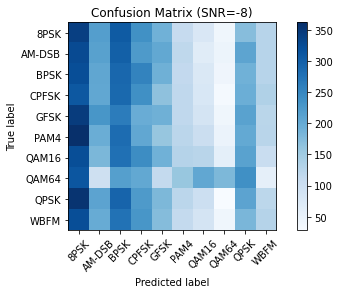


SNR =  -6
Accuracy =  0.1271621470817989
Train Accuracy =  1.0
Validation Accuracy =  0.13878504672897196
Avarege Overall Accuracy =  0.42198239793692366


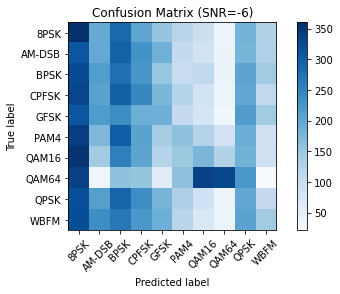


SNR =  -4
Accuracy =  0.1456087151841869
Train Accuracy =  1.0
Validation Accuracy =  0.1469035045607297
Avarege Overall Accuracy =  0.4308374065816389


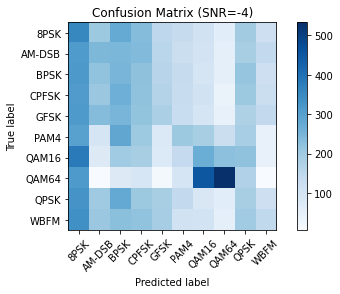


SNR =  -2
Accuracy =  0.17061663984015096
Train Accuracy =  1.0
Validation Accuracy =  0.17909002904162633
Avarege Overall Accuracy =  0.44990222296059246


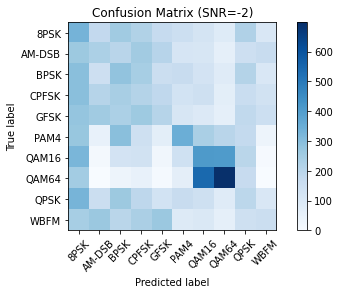


SNR =  0
Accuracy =  0.22537014360458643
Train Accuracy =  1.0
Validation Accuracy =  0.22061567164179105
Avarege Overall Accuracy =  0.48199527174879253


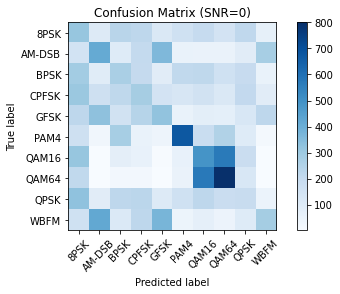


SNR =  2
Accuracy =  0.28732253771073646
Train Accuracy =  1.0
Validation Accuracy =  0.28974600188146754
Avarege Overall Accuracy =  0.5256895131974013


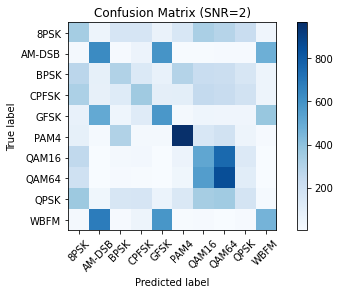


SNR =  4
Accuracy =  0.36396794694667034
Train Accuracy =  1.0
Validation Accuracy =  0.3642578125
Avarege Overall Accuracy =  0.5760752531488901


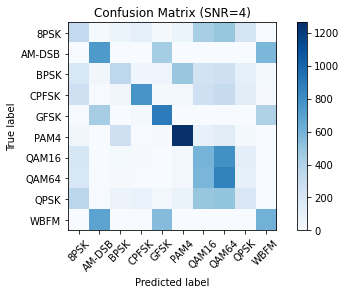


SNR =  6
Accuracy =  0.4678904170363798
Train Accuracy =  1.0
Validation Accuracy =  0.46894559460760715
Avarege Overall Accuracy =  0.645612003881329


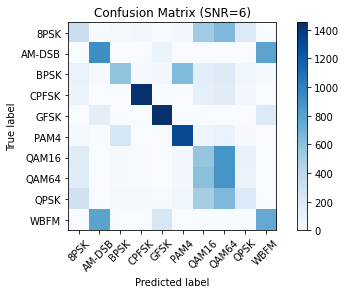


SNR =  8
Accuracy =  0.530186363129115
Train Accuracy =  1.0
Validation Accuracy =  0.5347744360902256
Avarege Overall Accuracy =  0.6883202664064468


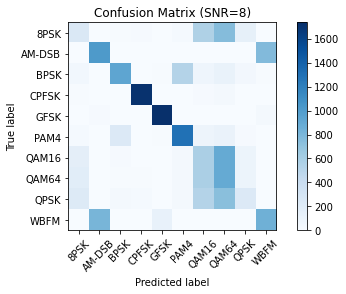


SNR =  10
Accuracy =  0.5625380991964533
Train Accuracy =  1.0
Validation Accuracy =  0.5466284074605452
Avarege Overall Accuracy =  0.7030555022189994


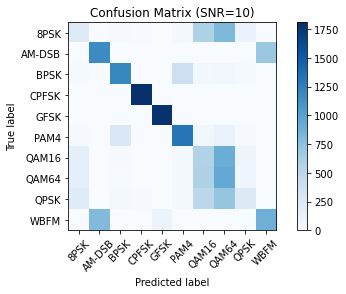


SNR =  12
Accuracy =  0.5818850267379679
Train Accuracy =  1.0
Validation Accuracy =  0.568560235063663
Avarege Overall Accuracy =  0.7168150872672103


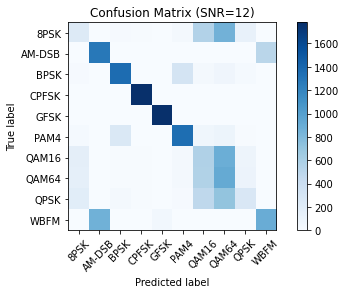


SNR =  14
Accuracy =  0.5933333333333334
Train Accuracy =  1.0
Validation Accuracy =  0.5793004312410158
Avarege Overall Accuracy =  0.7242112548581163


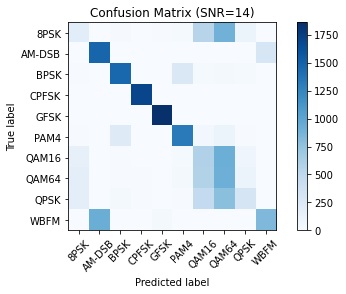


SNR =  16
Accuracy =  0.5995400235597689
Train Accuracy =  1.0
Validation Accuracy =  0.5954631379962193
Avarege Overall Accuracy =  0.7316677205186628


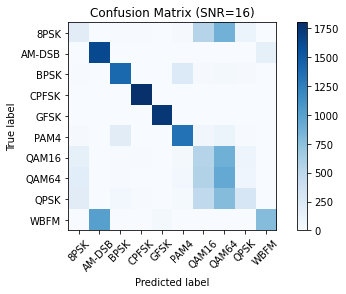


SNR =  18
Accuracy =  0.606006969412025
Train Accuracy =  1.0
Validation Accuracy =  0.6040268456375839
Avarege Overall Accuracy =  0.7366779383498696


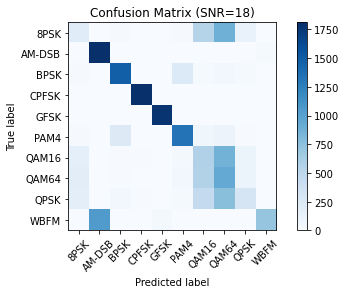

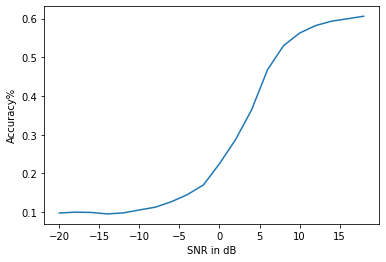

In [20]:
acc = random_forest_classifier(snrs, mods, X_train, X_test, X_val, trainY_mods, testY_mods, valY_mods, trainY_snr, testY_snr, valY_snr)
snr_plot(acc, snrs)

Model summary for this input: 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2, 128)            16512     
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 19,082
Trainable params: 19,082
Non-trainable params: 0
_________________________________________________________________
Start training for model: 
Epoch 1/100
780/780 - 5s - loss: 2.2617 - accuracy: 0.1678 - val_loss: 2.1704 - val_accuracy: 0.1997
INFO:tensorflow:Assets written to: /content/drive/MyDrive/College/Data_Mining_Assignments/Modulation_classification/data/assets
Epoch 2/100
780/780 - 3s - loss: 2.0699 - accuracy: 0.2211 - val_loss: 2.0006 - val_accuracy: 0

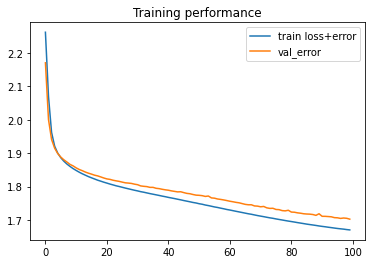

<Figure size 432x288 with 0 Axes>

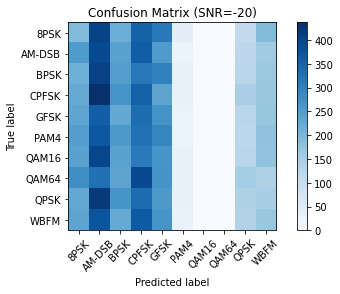


SNR =  -18
Accuracy =  0.09366375668825683
Train Accuracy =  0.12000697280605638
Validation Accuracy =  0.08999521302058401
Avarege Overall Accuracy =  0.10122198083829907


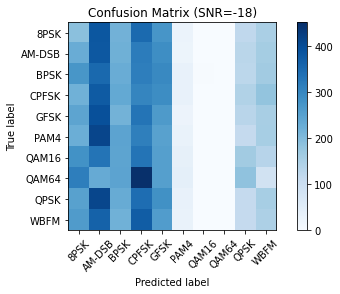


SNR =  -16
Accuracy =  0.10471609443246531
Train Accuracy =  0.11913729034849854
Validation Accuracy =  0.10311750599520383
Avarege Overall Accuracy =  0.10899029692538924


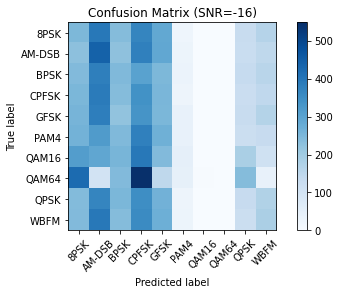


SNR =  -14
Accuracy =  0.10730392696073039
Train Accuracy =  0.12227624253721944
Validation Accuracy =  0.11975483262611976
Avarege Overall Accuracy =  0.1164450007080232


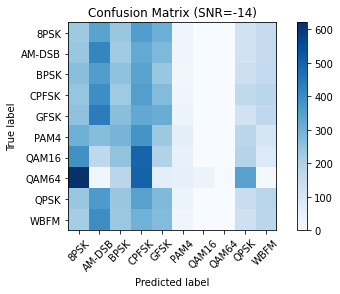


SNR =  -12
Accuracy =  0.11822167952489315
Train Accuracy =  0.13906104935638472
Validation Accuracy =  0.11267605633802817
Avarege Overall Accuracy =  0.12331959507310201


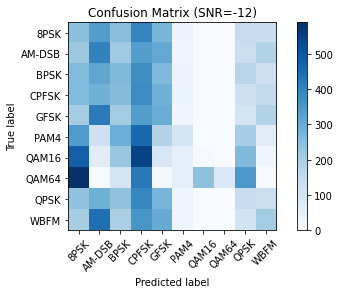


SNR =  -10
Accuracy =  0.16815583550696486
Train Accuracy =  0.18488237949541053
Validation Accuracy =  0.17750355956336022
Avarege Overall Accuracy =  0.17684725818857852


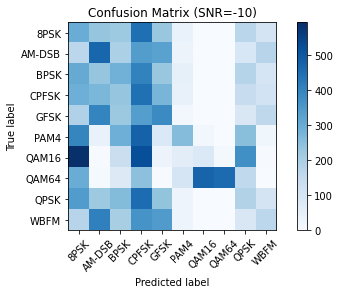


SNR =  -8
Accuracy =  0.24828615656789033
Train Accuracy =  0.27442059222764065
Validation Accuracy =  0.2591549295774648
Avarege Overall Accuracy =  0.26062055945766527


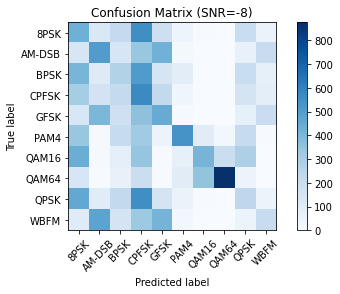


SNR =  -6
Accuracy =  0.3297065059703158
Train Accuracy =  0.35650257899744603
Validation Accuracy =  0.3149532710280374
Avarege Overall Accuracy =  0.3337207853319331


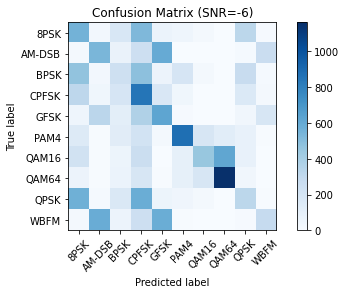


SNR =  -4
Accuracy =  0.3896001796945193
Train Accuracy =  0.4142960432820564
Validation Accuracy =  0.3874219875180029
Avarege Overall Accuracy =  0.3971060701648595


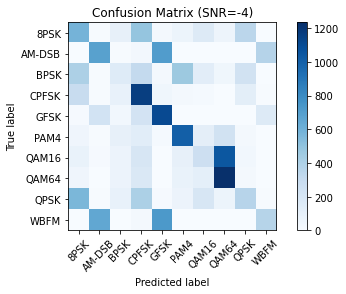


SNR =  -2
Accuracy =  0.4230449020369651
Train Accuracy =  0.4279129193075632
Validation Accuracy =  0.4027105517909003
Avarege Overall Accuracy =  0.4178894577118095


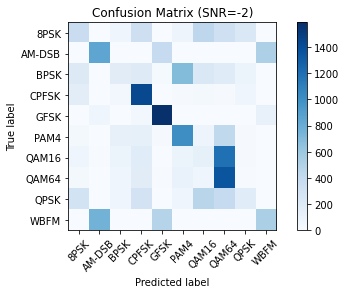


SNR =  0
Accuracy =  0.4505176444394968
Train Accuracy =  0.45500125344697917
Validation Accuracy =  0.4412313432835821
Avarege Overall Accuracy =  0.4489167470566861


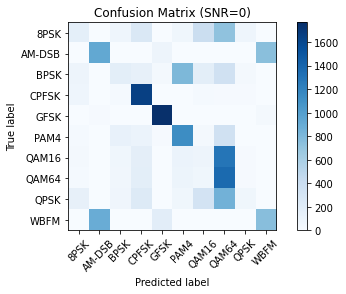


SNR =  2
Accuracy =  0.46262200532386866
Train Accuracy =  0.4589629034687014
Validation Accuracy =  0.4468485418626529
Avarege Overall Accuracy =  0.456144483551741


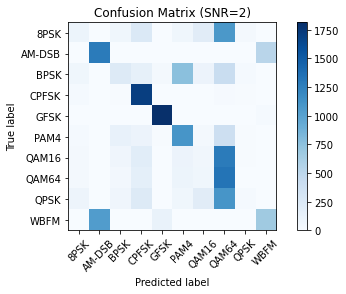


SNR =  4
Accuracy =  0.46869300911854106
Train Accuracy =  0.47166118874978047
Validation Accuracy =  0.46484375
Avarege Overall Accuracy =  0.4683993159561071


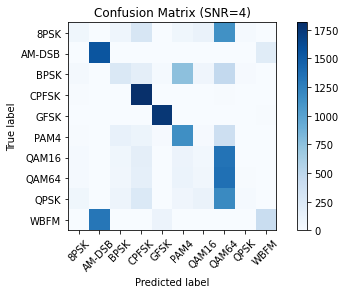


SNR =  6
Accuracy =  0.4678904170363798
Train Accuracy =  0.46905316988794465
Validation Accuracy =  0.477130476649013
Avarege Overall Accuracy =  0.47135802119111253


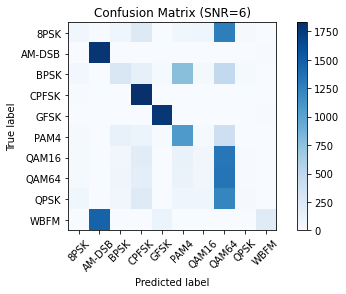


SNR =  8
Accuracy =  0.4649034705947997
Train Accuracy =  0.46685857321652063
Validation Accuracy =  0.4605263157894737
Avarege Overall Accuracy =  0.46409611986693133


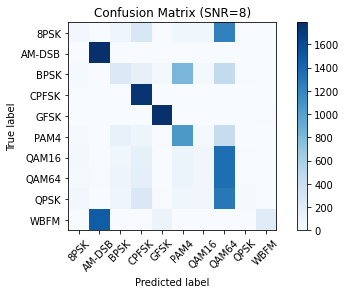


SNR =  10
Accuracy =  0.4713216957605985
Train Accuracy =  0.46708809953843067
Validation Accuracy =  0.430416068866571
Avarege Overall Accuracy =  0.45627528805520007


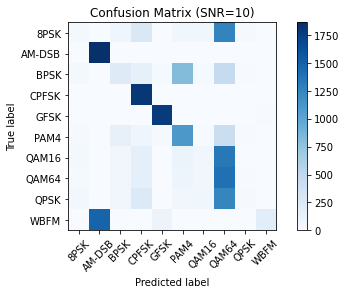


SNR =  12
Accuracy =  0.4629567736185383
Train Accuracy =  0.4658051292306154
Validation Accuracy =  0.47257590597453475
Avarege Overall Accuracy =  0.4671126029412295


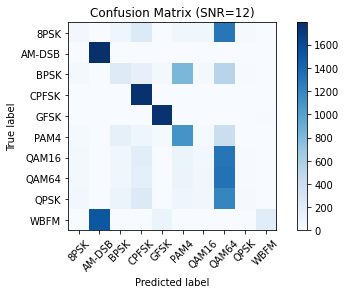


SNR =  14
Accuracy =  0.46255555555555555
Train Accuracy =  0.471124696214266
Validation Accuracy =  0.45615716339242934
Avarege Overall Accuracy =  0.463279138387417


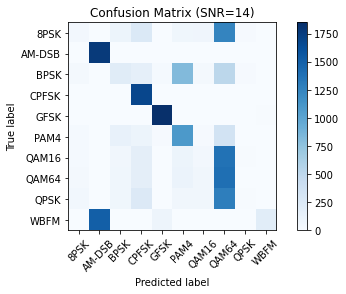


SNR =  16
Accuracy =  0.46508105682391876
Train Accuracy =  0.4690815587787403
Validation Accuracy =  0.45793950850661624
Avarege Overall Accuracy =  0.4640340413697584


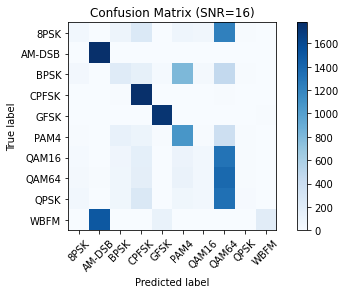


SNR =  18
Accuracy =  0.4692737430167598
Train Accuracy =  0.46898456131542615
Validation Accuracy =  0.47890699904122724
Avarege Overall Accuracy =  0.4723884344578044


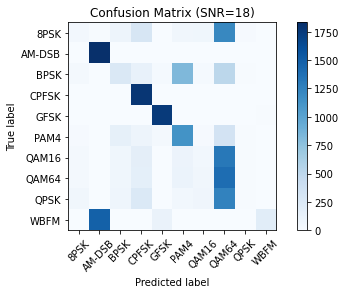

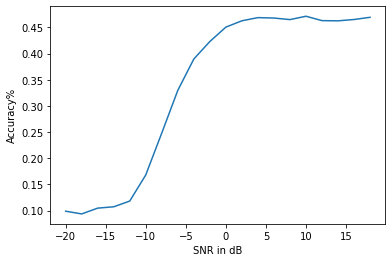

In [21]:
full_dense(trainX, trainY_mod10, valX, valY_mod10, testX)

Model summary for this input: 
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 1, 2, 128)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 2, 126)        256       
_________________________________________________________________
dropout (Dropout)            (None, 64, 2, 126)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 16, 1, 124)        6160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 1, 124)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1984)              0         
_________________________________________________________________
dense1 (Dense)         

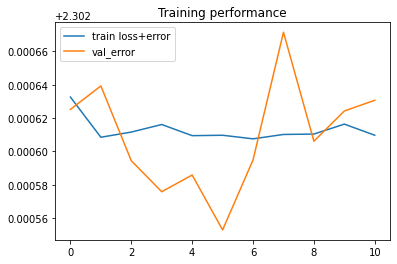

<Figure size 432x288 with 0 Axes>

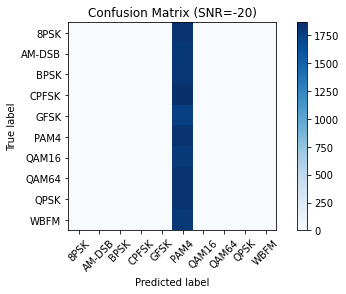


SNR =  -18
Accuracy =  0.09862010701210927
Train Accuracy =  0.09996015539396354
Validation Accuracy =  0.11249401627573001
Avarege Overall Accuracy =  0.10369142622726761


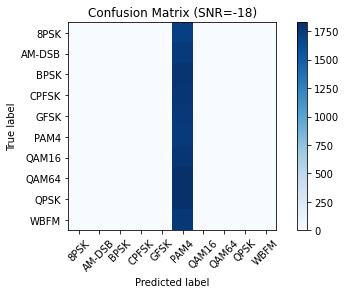


SNR =  -16
Accuracy =  0.09774976502460331
Train Accuracy =  0.10110977201968464
Validation Accuracy =  0.09832134292565947
Avarege Overall Accuracy =  0.0990602933233158


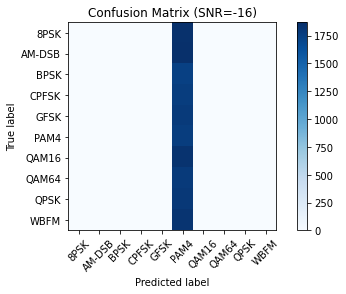


SNR =  -14
Accuracy =  0.1003189968100319
Train Accuracy =  0.10038541955311485
Validation Accuracy =  0.09005186232909006
Avarege Overall Accuracy =  0.09691875956407893


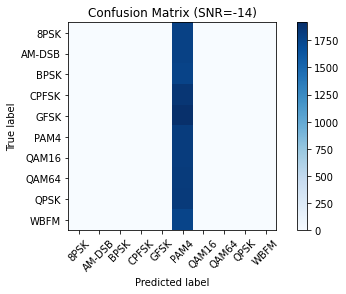


SNR =  -12
Accuracy =  0.09857356940667147
Train Accuracy =  0.10107143753293353
Validation Accuracy =  0.09201877934272301
Avarege Overall Accuracy =  0.09722126209410935


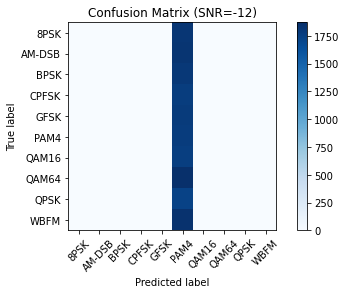


SNR =  -10
Accuracy =  0.10194794383706088
Train Accuracy =  0.09911220344083864
Validation Accuracy =  0.10014238253440912
Avarege Overall Accuracy =  0.10040084327076955


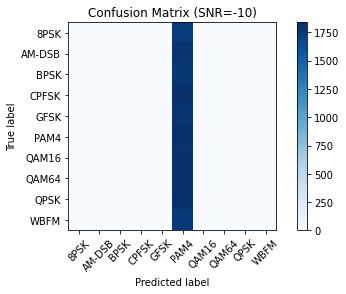


SNR =  -8
Accuracy =  0.09995577178239717
Train Accuracy =  0.10022120557035845
Validation Accuracy =  0.09624413145539906
Avarege Overall Accuracy =  0.0988070362693849


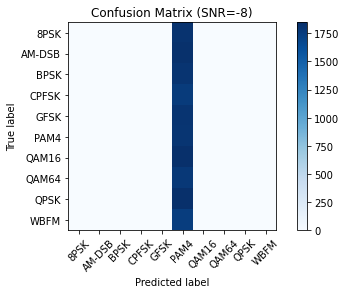


SNR =  -6
Accuracy =  0.10082580069188707
Train Accuracy =  0.09962942560969502
Validation Accuracy =  0.1
Avarege Overall Accuracy =  0.10015174210052737


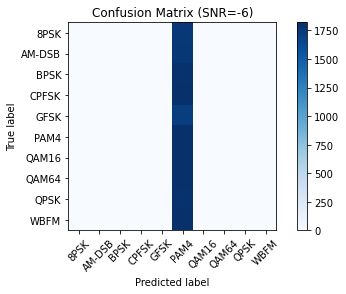


SNR =  -4
Accuracy =  0.09551886792452831
Train Accuracy =  0.10174773741554265
Validation Accuracy =  0.10465674507921267
Avarege Overall Accuracy =  0.10064111680642789


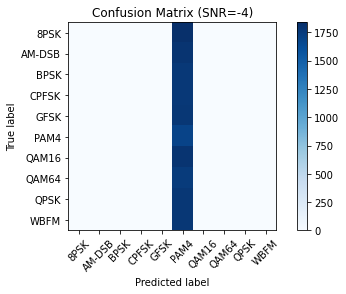


SNR =  -2
Accuracy =  0.10195926069822946
Train Accuracy =  0.09913069619460381
Validation Accuracy =  0.09970958373668926
Avarege Overall Accuracy =  0.10026651354317417


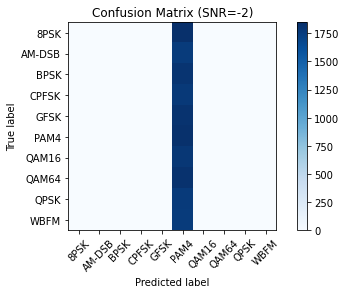


SNR =  0
Accuracy =  0.10007792496938663
Train Accuracy =  0.09949862120832288
Validation Accuracy =  0.10867537313432836
Avarege Overall Accuracy =  0.10275063977067929


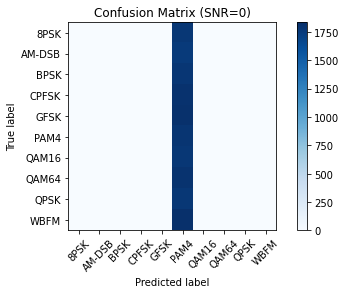


SNR =  2
Accuracy =  0.10021073646850044
Train Accuracy =  0.10019577330455298
Validation Accuracy =  0.09454374412041393
Avarege Overall Accuracy =  0.09831675129782246


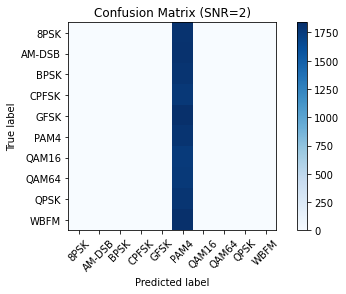


SNR =  4
Accuracy =  0.10146449295385465
Train Accuracy =  0.09915447725619088
Validation Accuracy =  0.103515625
Avarege Overall Accuracy =  0.1013781984033485


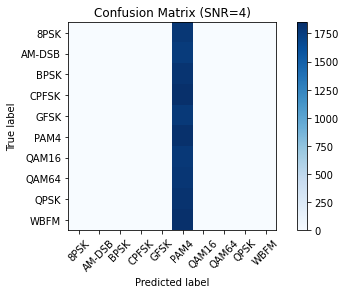


SNR =  6
Accuracy =  0.09743788819875776
Train Accuracy =  0.10112556717053972
Validation Accuracy =  0.1006259027443428
Avarege Overall Accuracy =  0.09972978603788009


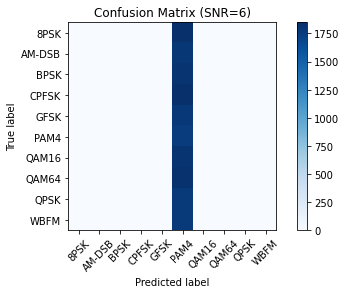


SNR =  8
Accuracy =  0.09943086709072649
Train Accuracy =  0.1002503128911139
Validation Accuracy =  0.10009398496240601
Avarege Overall Accuracy =  0.09992505498141546


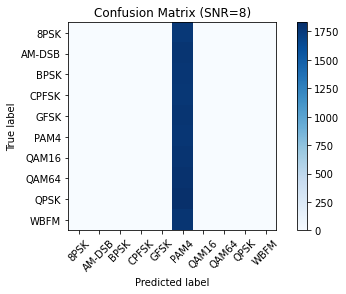


SNR =  10
Accuracy =  0.10069271266278748
Train Accuracy =  0.09946317479430063
Validation Accuracy =  0.10425633668101388
Avarege Overall Accuracy =  0.10147074137936733


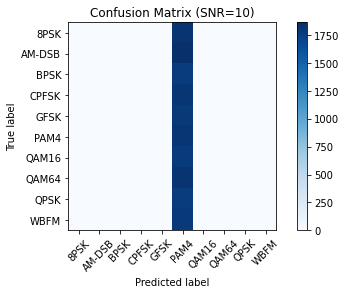


SNR =  12
Accuracy =  0.10043449197860962
Train Accuracy =  0.10013497975303705
Validation Accuracy =  0.09353574926542606
Avarege Overall Accuracy =  0.0980350736656909


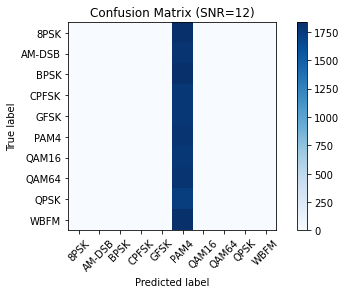


SNR =  14
Accuracy =  0.09727777777777778
Train Accuracy =  0.10106982687344976
Validation Accuracy =  0.1030186871106852
Avarege Overall Accuracy =  0.10045543058730426


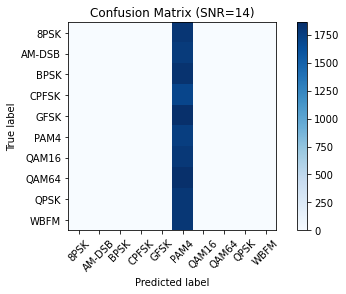


SNR =  16
Accuracy =  0.09687552588769843
Train Accuracy =  0.10128067503807076
Validation Accuracy =  0.10207939508506617
Avarege Overall Accuracy =  0.10007853200361179


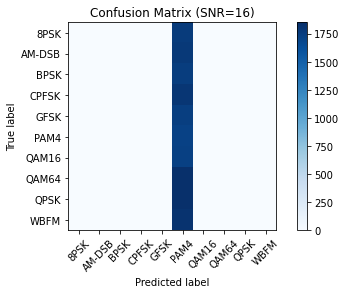


SNR =  18
Accuracy =  0.09934177775319432
Train Accuracy =  0.09943517007656584
Validation Accuracy =  0.11649089165867689
Avarege Overall Accuracy =  0.10508927982947902


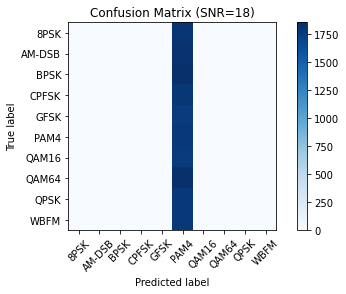

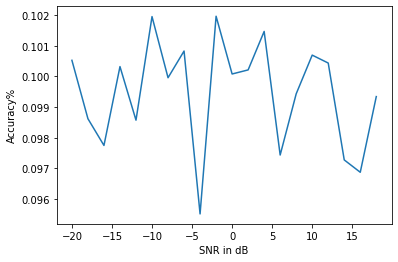

In [22]:
CnnModel(trainX,trainY_mod10,valX,valY_mod10,testX,testY_mod10)